### The first half of the script is on the descriptive grpahs of NER and NER/DTM. At the very bottom of the script, you find the code for the sentiment anaylsis.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!ls /content/drive/

Mounted at /content/drive
MyDrive


**Text fett markieren**# Ner bert

In [ ]:
!pip install pandas
!pip install spacy
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn

In [ ]:
import nltk
import spacy
from collections import Counter
import pandas as pd
import ast
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import numpy as np
nltk.download('vader_lexicon')
nltk.download('punkt')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:

path_to_df = '/content/drive/MyDrive/Colab Notebooks/ner_predictions_with_categories3.csv'
df = pd.read_csv(path_to_df)

df_subset = df[df['Category'] != 'No Entity']

## I decided later to adjust the Topic category names and also add the average class sharefor the topic/entity plot!


print(df_subset.head())

# Some renaming and aligning of names (with updated cluster names)
df_subset['Topic Category'] = df_subset['Topic Category'].replace({
    "Mining communities": "Mining affected communities",
    "State role in mining": "Politics in mining & energy",
    "Transition Politics": "Transition politics"

})

print(df_subset.head(10))

# Topic cluster share (calculated from the dtm model output)
topic_category_shares = {
    "Mining industry": 0.2255,
    "Transition politics": 0.1846,
    "Mining affected communities": 0.1355,
    "Energy crisis": 0.1527,
    "Politics in mining & energy": 0.3017
}

# adding the respective column to the dtaframe
df_subset['Topic Category Shares'] = df_subset['Topic Category'].map(topic_category_shares)

print(df_subset.head())


                                             Sentence  \
1   Environmental groups rejected the dominance of...   
15  The problem of relying upon these actors to sa...   
16  The problem of relying upon these actors to sa...   
18  If Zuma aims, therefore, to persuade the world...   
20  The cuts promised by Sonjica just before Copen...   

                           Dominant Topic  Year  Month            Entity  \
1                            Eskom crisis  2010      1             Eskom   
15  Transition politics & climate finance  2010      1             Eskom   
16  Transition politics & climate finance  2010      1               ANC   
18  Transition politics & climate finance  2010      1        Jacob Zuma   
20  Transition politics & climate finance  2010      1  Earthlife Africa   

      Type   Category       Topic Category Broad Category  
1      ORG      Eskom        Energy crisis          Eskom  
15     ORG      Eskom  Transition Politics          Eskom  
16     ORG  Politica

<ipython-input-16-fd0ed67533d1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['Topic Category'] = df_subset['Topic Category'].replace({
<ipython-input-16-fd0ed67533d1>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['Topic Category Shares'] = df_subset['Topic Category'].map(topic_category_shares)


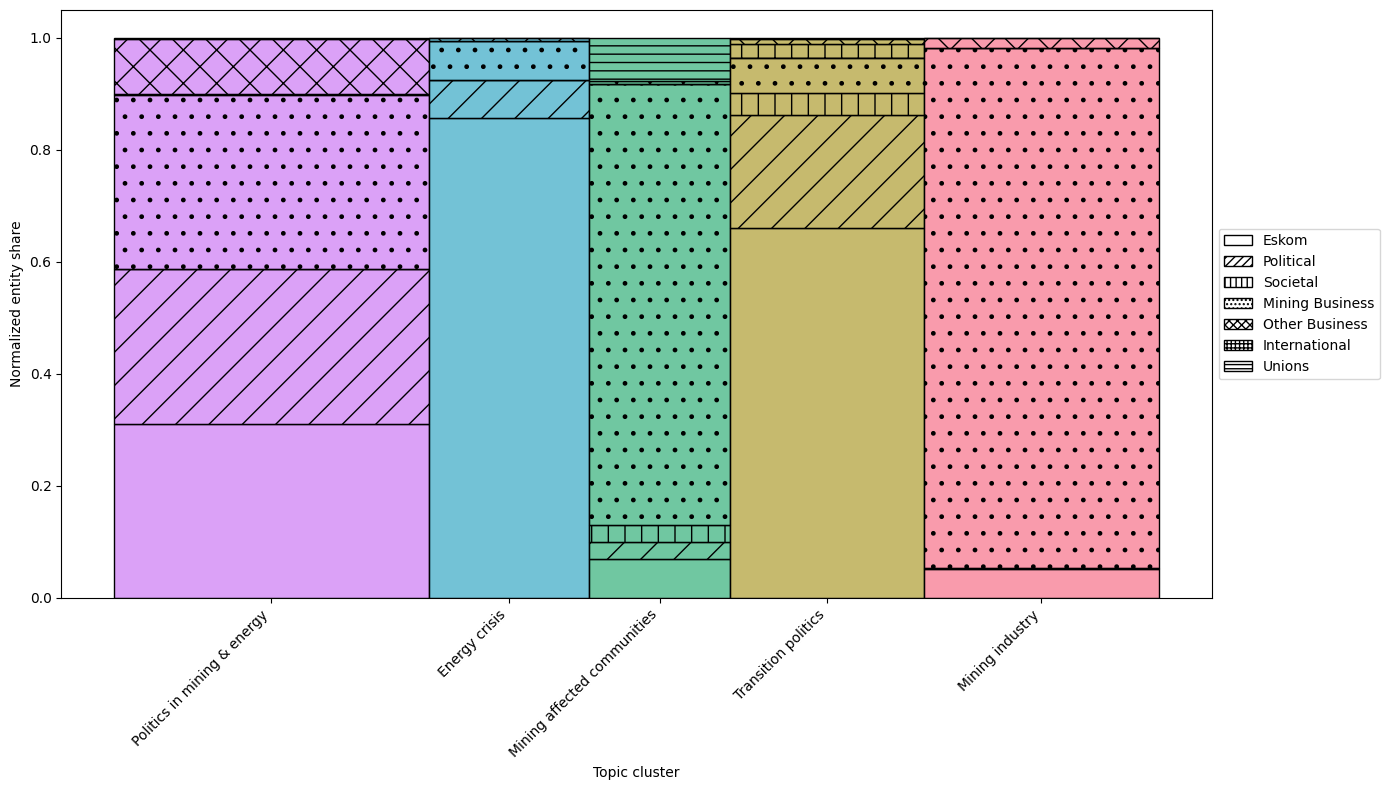

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch

path_to_df = '/content/drive/MyDrive/Colab Notebooks/ner_predictions_with_categories3.csv'
df = pd.read_csv(path_to_df)

# filter out 'no entity"
df_subset = df[df['Category'] != 'No Entity'].copy()

# Some renaming and aligning of names (with updated cluster names)
df_subset.loc[:, 'Topic Category'] = df_subset['Topic Category'].replace({
    "Mining communities": "Mining affected communities",
    "State role in mining": "Politics in mining & energy",
    "Transition Politics": "Transition politics"

})

# Topic cluster share (calculated from the dtm model output)
class_shares = {
    "Mining industry": 0.2255,
    "Transition politics": 0.1846,
    "Mining affected communities": 0.1355,
    "Energy crisis": 0.1527,
    "Politics in mining & energy": 0.3017
}

# adding the respective column to the dtaframe
df_subset.loc[:, 'Class Share'] = df_subset['Topic Category'].map(class_shares)

# mormalize entity/actor shares within each topic cluster
df_subset.loc[:, 'Entity Count'] = df_subset.groupby(['Topic Category', 'Category'])['Sentence'].transform('count')
df_subset.loc[:, 'Normalized Entity Share'] = df_subset['Entity Count'] / df_subset.groupby('Topic Category')['Entity Count'].transform('sum')

categories = df_subset['Category'].unique()
topic_categories = df_subset['Topic Category'].unique()

# custom order for the topic categories
custom_order = [
    "Politics in mining & energy",
    "Energy crisis",
    "Mining affected communities",
    "Transition politics",
    "Mining industry"
]

# colors
class_colors = sns.color_palette("husl", len(class_shares))
class_colors_with_alpha = [(r, g, b, 0.7) for r, g, b in class_colors]  # Add alpha transparency
class_color_map = {cls: color for cls, color in zip(class_shares.keys(), class_colors_with_alpha)}

#patterns
entity_patterns = {
    "Eskom": "",
    "Political": "/",
    "Societal": "|",
    "Mining Business": ".",
    "Other Business": "x",
    "International": "+",
    "Unions": "--"
}

# pattern for legend has to be denser, othersie don't see
legend_entity_patterns = {
    "Eskom": "",
    "Political": "////",
    "Societal": "|||",
    "Mining Business": "....",
    "Other Business": "xxxx",
    "International": "++++",
    "Unions": "----"
}

fig, ax = plt.subplots(figsize=(14, 8))

added_labels = set()

# Plot the area chart for each Topic Category
left = 0  # Starting position of the first bar
for topic_category in custom_order:
    class_share = class_shares[topic_category]  # Width of the bar
    bottom = 0
    for category in categories:
        entity_share = df_subset[(df_subset['Topic Category'] == topic_category) & (df_subset['Category'] == category)]['Normalized Entity Share'].sum()
        if entity_share > 0:
            label = category if category not in added_labels else "_nolegend_"
            ax.bar(
                left + class_share / 2, entity_share, width=class_share, bottom=bottom,
                color=class_color_map[topic_category], edgecolor="black", hatch=entity_patterns.get(category, ""),
                align='center', label=label
            )
            bottom += entity_share
            added_labels.add(category)
    left += class_share

# Customize the plot
ax.set_xlabel('Topic cluster')
ax.set_ylabel('Normalized entity share')
#ax.set_title('Topic Category Shares with Entity Category Patterns')

# Create custom x-ticks
x_ticks = np.cumsum([0] + [class_shares[tc] for tc in custom_order[:-1]]) + np.array([class_shares[tc] / 2 for tc in custom_order])
ax.set_xticks(x_ticks)
ax.set_xticklabels(custom_order, rotation=45, ha='right')

# Create legend with white background
legend_handles = [Patch(facecolor='white', edgecolor='black', hatch=legend_entity_patterns[category], label=category) for category in legend_entity_patterns]
ax.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.5))

# Display the plot
plt.tight_layout()
plt.show()


In [ ]:
df_subset.head(20)


,Sentence,Dominant Topic,Year,Month,Entity,Type,Category,Topic Category,Broad Category,Class Share,Entity Count,Normalized Entity Share
1,Environmental groups rejected the dominance of...,Eskom crisis,2010,1,Eskom,ORG,Eskom,Energy crisis,Eskom,0.1527,1251,0.000686
15,The problem of relying upon these actors to sa...,Transition politics & climate finance,2010,1,Eskom,ORG,Eskom,Transition politics,Eskom,0.1846,746,0.000885
16,The problem of relying upon these actors to sa...,Transition politics & climate finance,2010,1,ANC,ORG,Political,Transition politics,Political,0.1846,413,0.000490
18,"If Zuma aims, therefore, to persuade the world...",Transition politics & climate finance,2010,1,Jacob Zuma,PERSON,Political,Transition politics,Political,0.1846,413,0.000490
20,The cuts promised by Sonjica just before Copen...,Transition politics & climate finance,2010,1,Earthlife Africa,ORG,Societal,Transition politics,Societal,0.1846,181,0.000215
22,"In reality, cuts promised in the Long-Term Mit...",Transition politics & climate finance,2010,1,Sasol,ORG,Mining Business,Transition politics,Business,0.1846,229,0.000272
23,As the Eskom tariff hearings organised by the ...,Transition politics & climate finance,2010,1,Eskom,ORG,Eskom,Transition politics,Eskom,0.1846,746,0.000885
24,Yet the purpose of the new build programme is ...,Transition politics & climate finance,2010,1,Eskom,ORG,Eskom,Transition politics,Eskom,0.1846,746,0.000885
30,The department called this month for public co...,Anti-mining activism,2010,1,Eskom,ORG,Eskom,Mining affected communities,Eskom,0.1355,240,0.000294
31,Several mines are expected to be developed in ...,Anti-mining activism,2010,1,Eskom,ORG,Eskom,Mining affected communities,Eskom,0.1355,240,0.000294


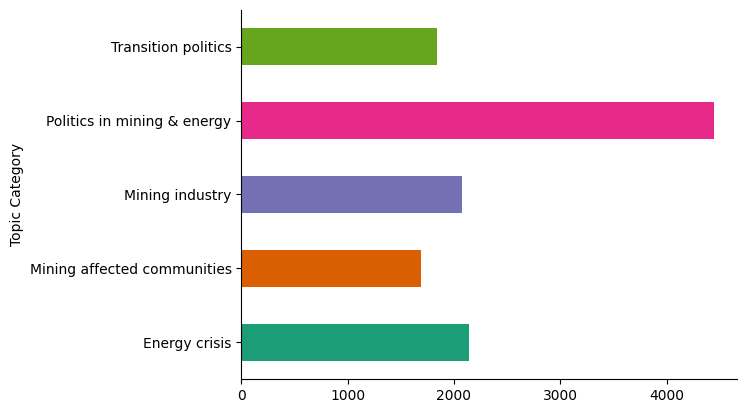

In [ ]:
#Topic Category

df_subset.groupby('Topic Category').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

<ipython-input-69-5bd5f8b5ab9e>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df_subset, x='Year', y='Category', inner='box', palette='Dark2')


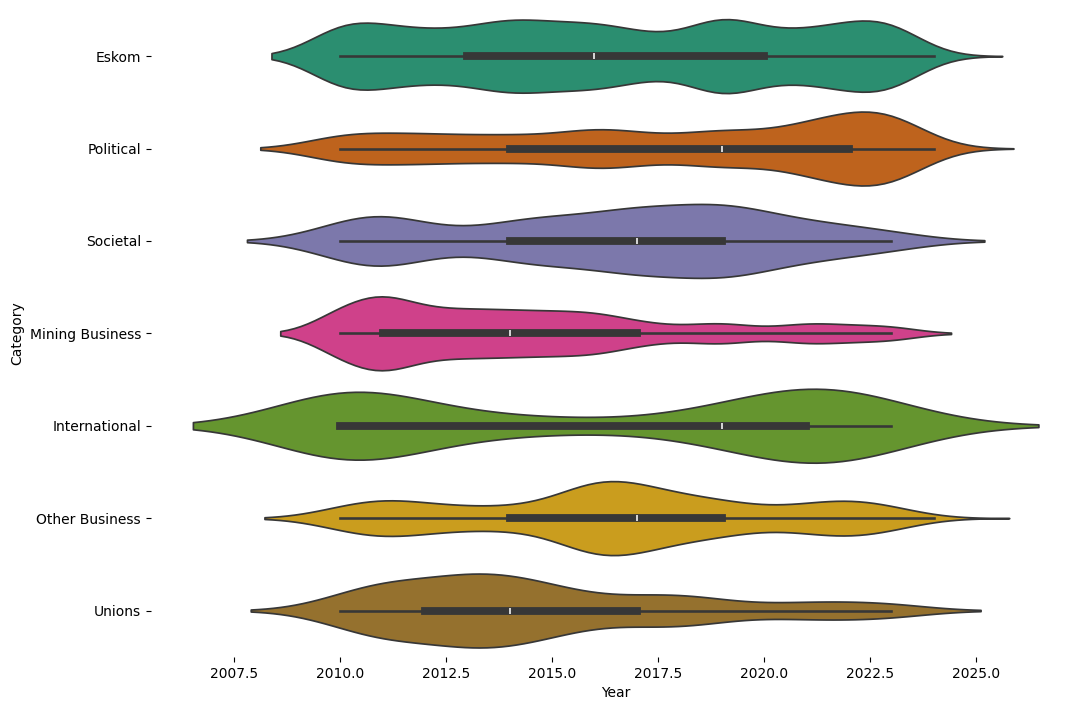

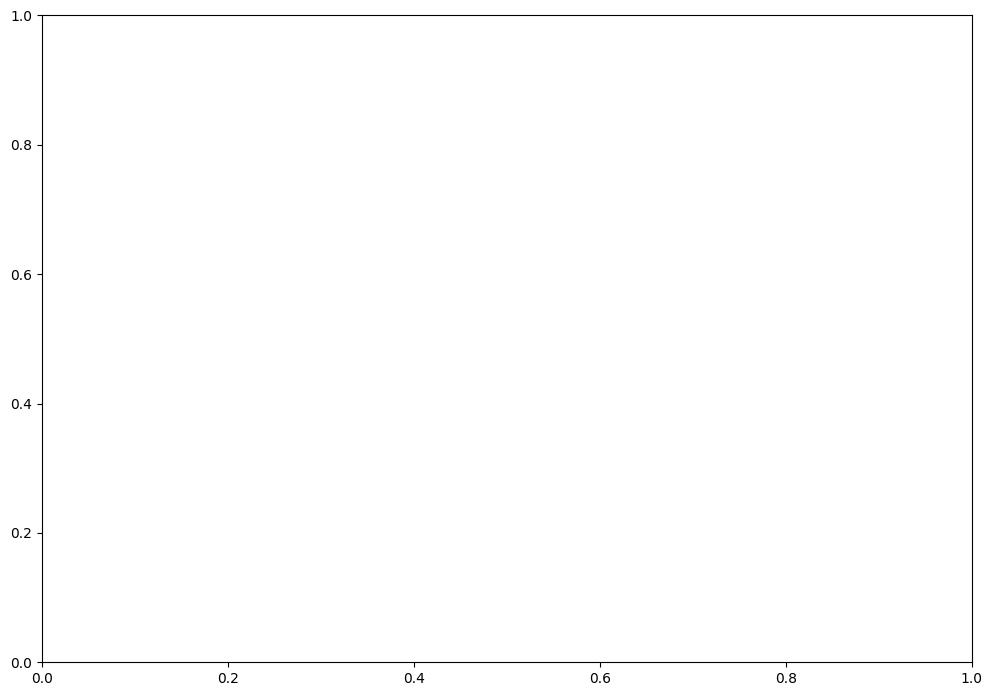

<ipython-input-69-5bd5f8b5ab9e>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=df_subset, x='YearMonth', y='Category', jitter=True, palette='Dark2', ax=ax)


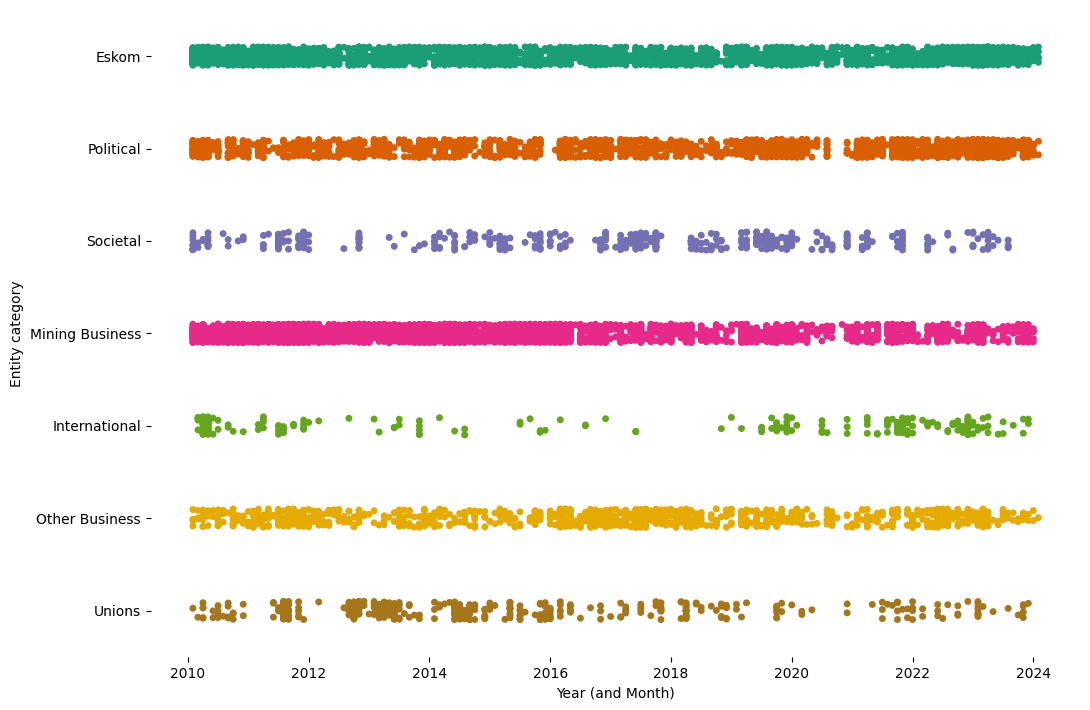

In [ ]:

### IGNORE THIS CODE
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_subset['Category'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_subset, x='Year', y='Category', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)
ax.set_ylabel('Entity category')

fig, ax = plt.subplots(figsize=(12, 1.2 * len(df_subset['Category'].unique())))


plt.show()

fig, ax = plt.subplots(figsize=(12, 1.2 * len(df_subset['Category'].unique())))

df_subset['YearMonth'] = df_subset['Year'] + df_subset['Month'] / 12

# Create a strip plot
sns.stripplot(data=df_subset, x='YearMonth', y='Category', jitter=True, palette='Dark2', ax=ax)
#ax.set_title('Year and Month by Category')
ax.set_xlabel('Year (and Month)')
ax.set_ylabel('Entity category')

# Customize the plot to despine
sns.despine(top=True, right=True, bottom=True, left=True)
plt.show()


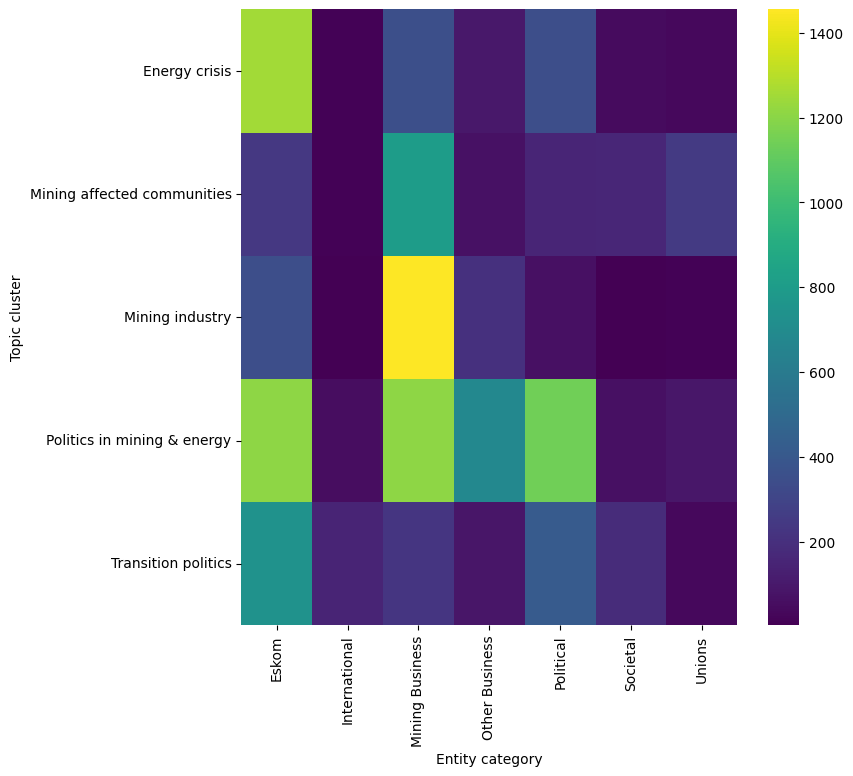

In [ ]:

plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Topic Category'].value_counts()
    for x_label, grp in df_subset.groupby('Category')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Entity category')
_ = plt.ylabel('Topic cluster')

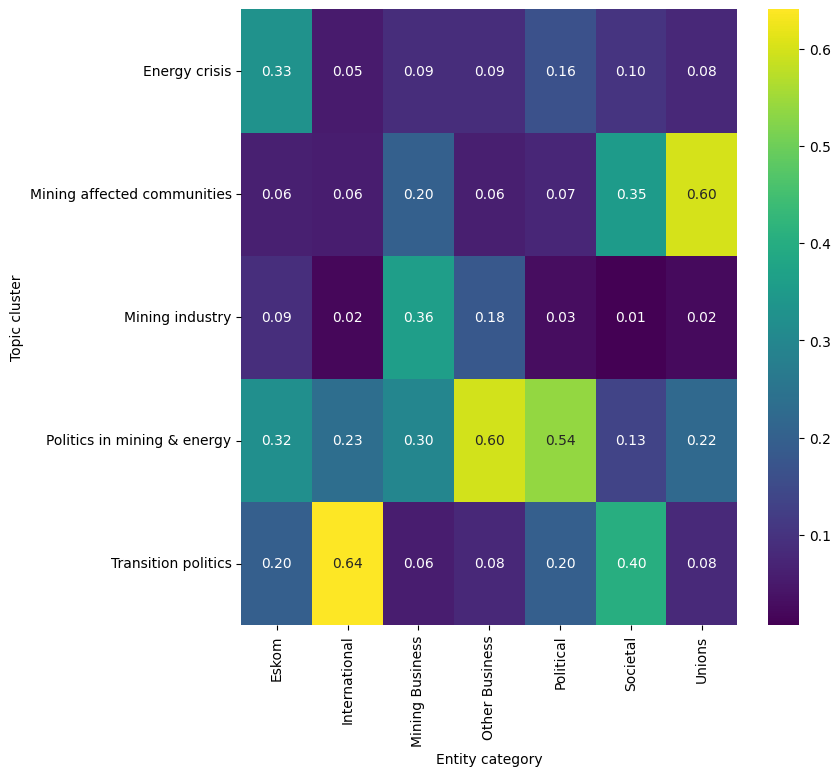

In [ ]:
# ignore

plt.subplots(figsize=(8, 8))

df_2dhist = pd.DataFrame({
    x_label: grp['Topic Category'].value_counts(normalize=True)  # normalize=True to get relative shares
    for x_label, grp in df_subset.groupby('Category')
}).fillna(0)  # Fill NaNs with 0 for missing values

sns.heatmap(df_2dhist, cmap='viridis', annot=True, fmt=".2f")
plt.xlabel('Entity category')
plt.ylabel('Topic cluster')
#plt.title('Category vs Topic Category (Relative Shares)')
plt.show()


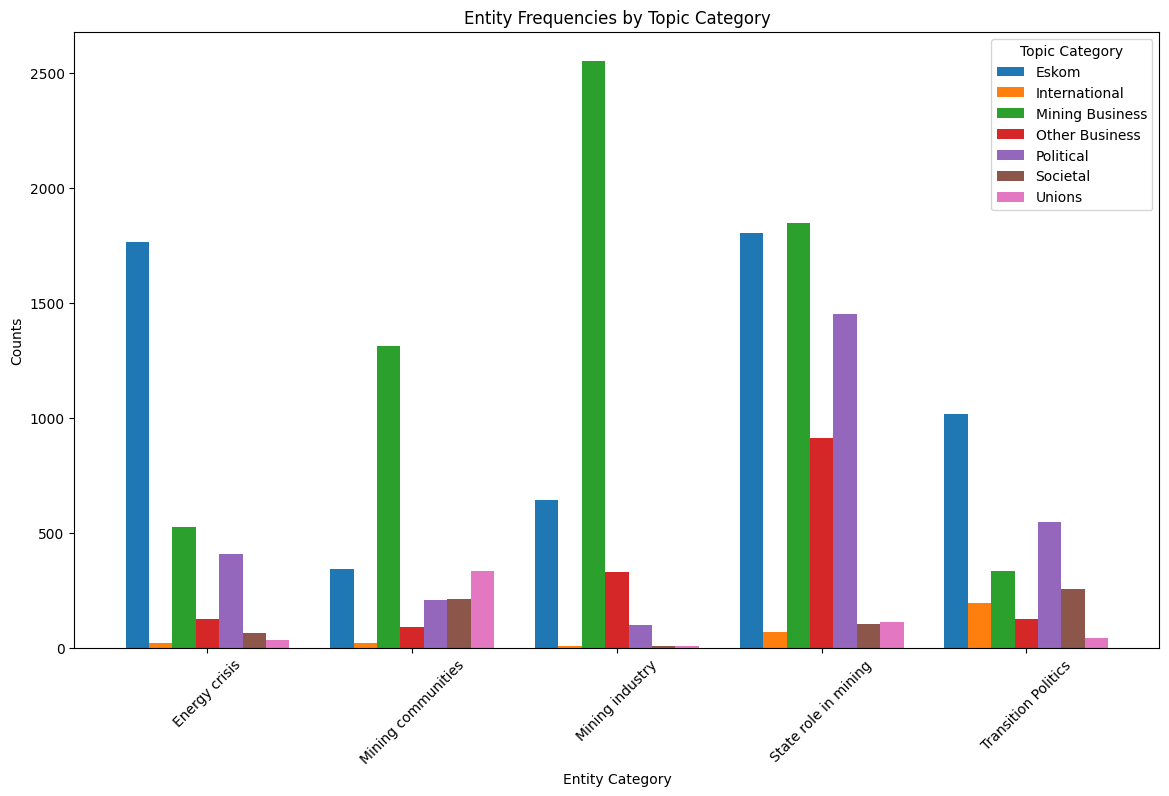

In [ ]:
# ignore

# Count observations per Category and Topic Category
category_topic_category_counts = df_subset.groupby(['Topic Category', 'Category']).size().reset_index(name='Counts')




# Pivot to create a matrix suitable for a grouped bar chart
pivot_table = category_topic_category_counts.pivot(index='Topic Category', columns='Category', values='Counts').fillna(0)

# Plot grouped bar chart
ax = pivot_table.plot(kind='bar', figsize=(14, 8), width=0.8)
ax.set_xlabel("Entity Category")
ax.set_ylabel("Counts")
ax.set_title("Entity Frequencies by Topic Category")
plt.xticks(rotation=45)
plt.legend(title="Topic Category")
plt.show()



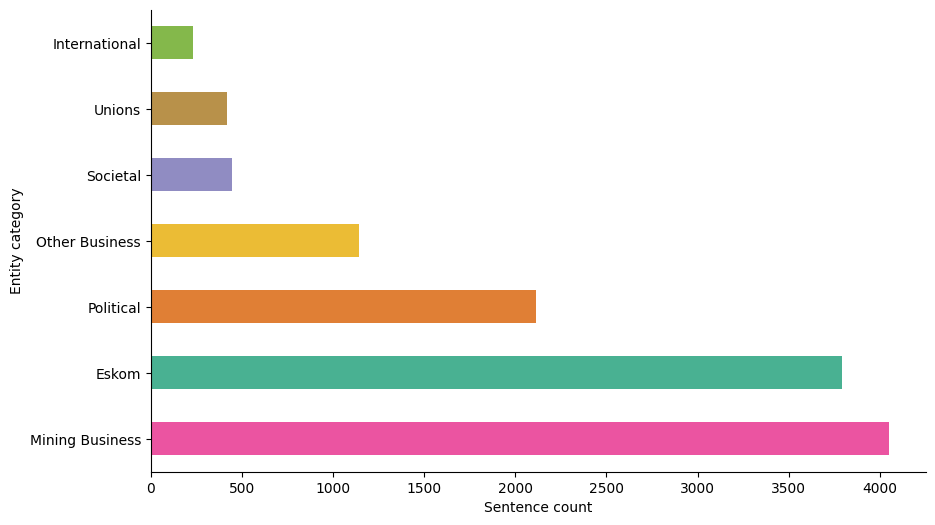

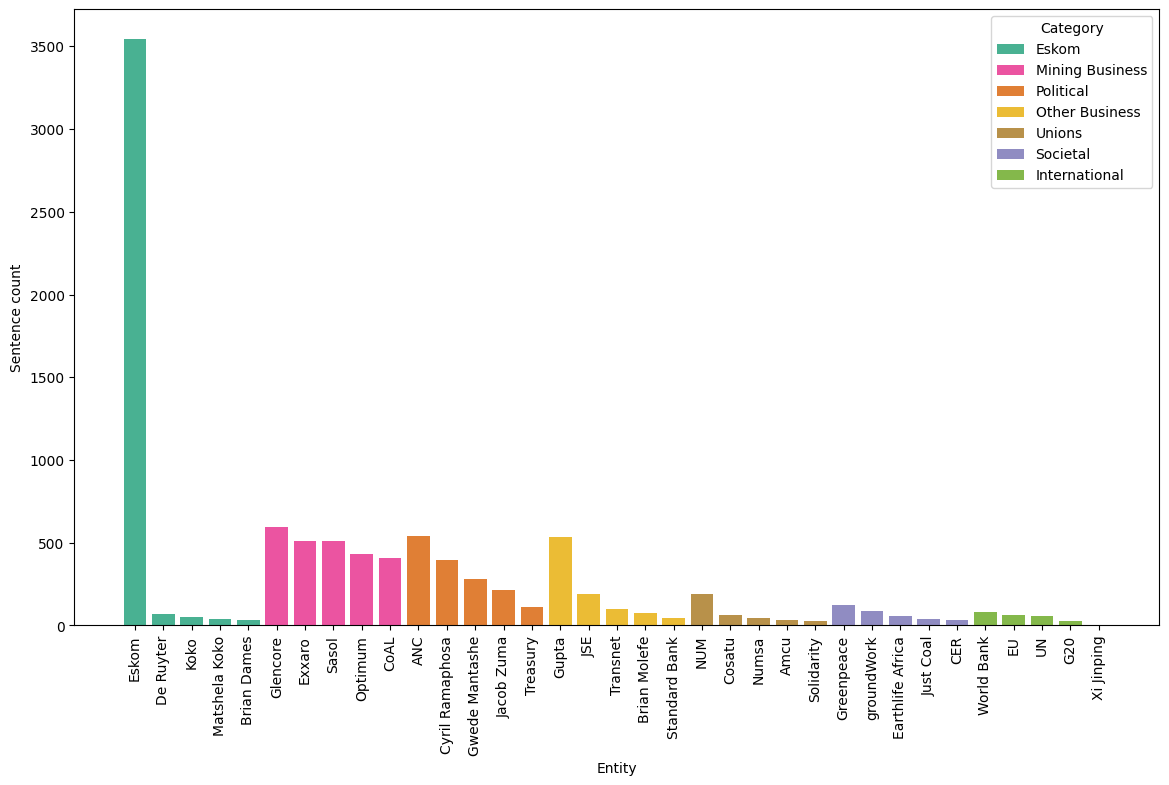

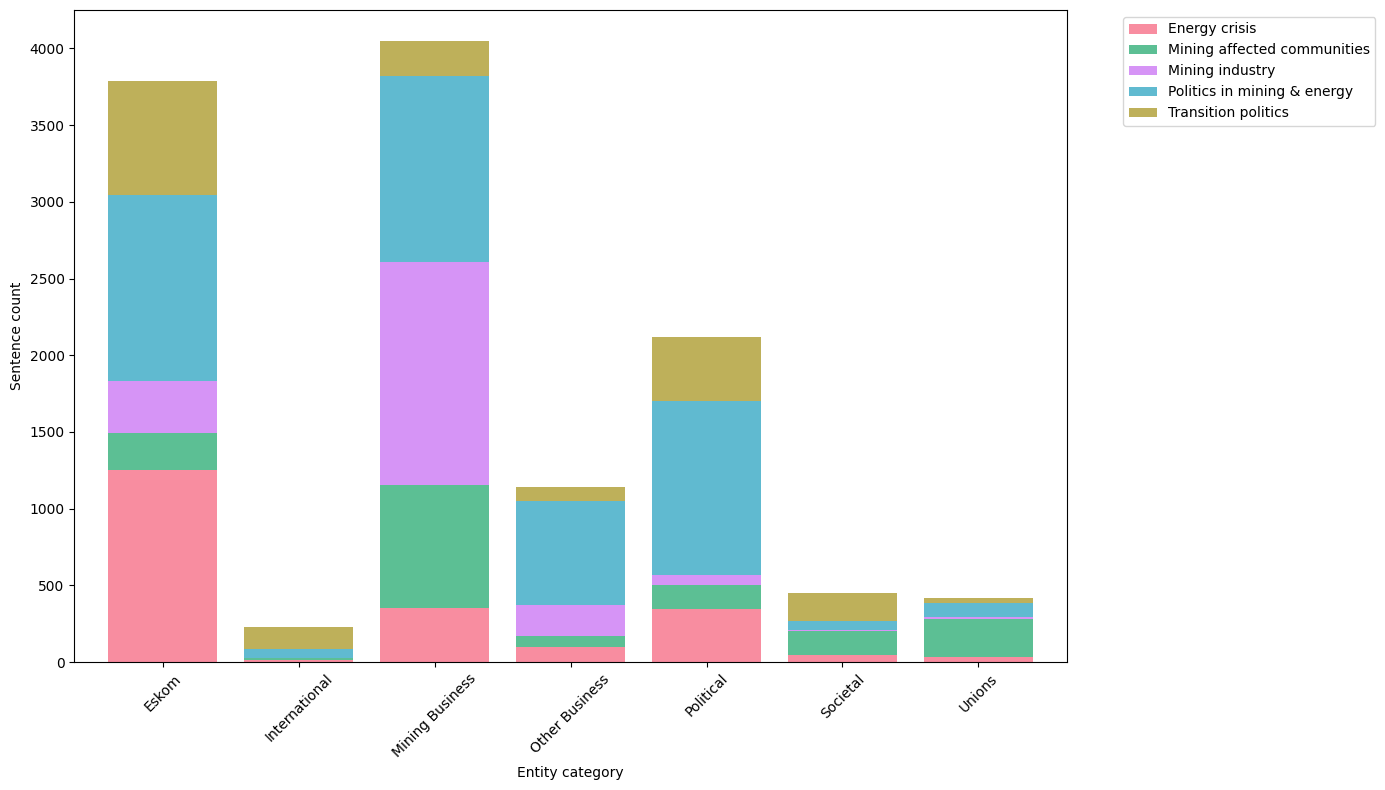

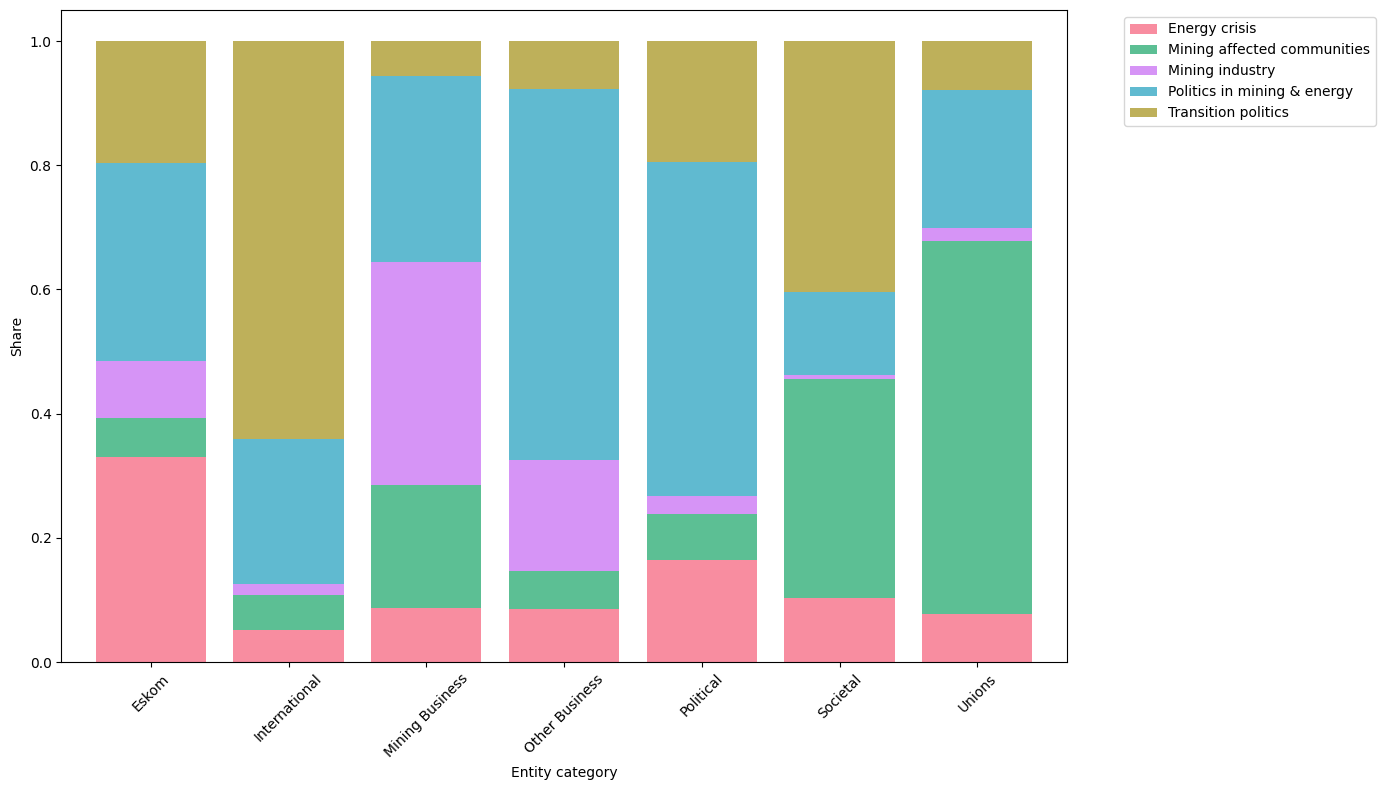

In [ ]:
# ignore


topic_categories = df_subset['Topic Category'].unique()
class_colors = sns.color_palette("husl", len(topic_categories))
class_colors_with_alpha = [(r, g, b, 0.8) for r, g, b in class_colors]  # Add alpha transparency
class_color_map = {cls: color for cls, color in zip(topic_categories, class_colors_with_alpha)}

categories = df_subset['Category'].unique()
category_colors = sns.color_palette("Dark2", len(categories))
category_color_map = {category: color for category, color in zip(categories, category_colors)}

# Sentence count by category
plt.figure(figsize=(10, 6))
category_counts = df_subset['Category'].value_counts()
category_counts.plot(kind='barh', color=[category_color_map[cat] for cat in category_counts.index], alpha=0.8)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.ylabel("Entity category")
plt.xlabel("Sentence count")
#plt.title("Sentence count by Category")
plt.show()

# Second plot
# Calculate the 10 most occurring entities by topic category
#top_entities_by_topic_category = df_subset.groupby(['Entity', 'Topic Category']).size().reset_index(name='Counts')
#top_entities_by_topic_category = top_entities_by_topic_category.sort_values(by='Counts', ascending=False).groupby('Topic Category').head(10)

# Plot top 10 entities by topic category


# Third plot
# Calculate the 10 most occurring entities by category
top_entities_by_category = df_subset.groupby(['Entity', 'Category']).size().reset_index(name='Counts')
top_entities_by_category = top_entities_by_category.sort_values(by='Counts', ascending=False).groupby('Category').head(5)

# Plot top 10 entities by category
plt.figure(figsize=(14, 8))
for category in top_entities_by_category['Category'].unique():
    subset = top_entities_by_category[top_entities_by_category['Category'] == category]
    plt.bar(subset['Entity'], subset['Counts'], label=category, color=category_color_map[category], alpha=0.8)

plt.xlabel("Entity")
plt.ylabel("Sentence count")
#plt.title("Top 10 Most Occurring Entities by Category")
plt.xticks(rotation=90)
plt.legend(title="Category")
plt.show()

# Fourth plot
# Count observations per Category and Topic Category
category_topic_category_counts = df_subset.groupby(['Category', 'Topic Category']).size().reset_index(name='Counts')

# Pivot to create a matrix suitable for a stacked bar chart
pivot_table = category_topic_category_counts.pivot(index='Category', columns='Topic Category', values='Counts').fillna(0)

# Plot stacked bar chart
pivot_table.plot(kind='bar', stacked=True, figsize=(14, 8), width=0.8, color=[class_color_map[topic] for topic in pivot_table.columns])
plt.xlabel("Entity category")
plt.ylabel("Sentence count")
#plt.title("Entity Frequencies by Category and Topic Category")
plt.xticks(rotation=45)
plt.legend(title=None, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Fifth plot
# Convert counts to percentages
pivot_table_percentage = pivot_table.div(pivot_table.sum(axis=1), axis=0)

# Plot stacked bar chart with percentages
pivot_table_percentage.plot(kind='bar', stacked=True, figsize=(14, 8), width=0.8, color=[class_color_map[topic] for topic in pivot_table_percentage.columns])
plt.xlabel("Entity category")
plt.ylabel("Share")
#plt.title("Category and Topic Category (normalized)")
plt.xticks(rotation=45)
plt.legend(title=None, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

                                             Sentence  \
1   Environmental groups rejected the dominance of...   
16  The problem of relying upon these actors to sa...   
17  The problem of relying upon these actors to sa...   
19  If Zuma aims, therefore, to persuade the world...   
21  The cuts promised by Sonjica just before Copen...   

                           Dominant Topic  Year  Month            Entity  \
1                            Eskom crisis  2010      1             Eskom   
16  Transition politics & climate finance  2010      1             Eskom   
17  Transition politics & climate finance  2010      1               ANC   
19  Transition politics & climate finance  2010      1              Zuma   
21  Transition politics & climate finance  2010      1  Earthlife Africa   

      Type   Category       Topic Category Time Period  Compound  Positive  \
1      ORG      Eskom        Energy crisis   2010-2015     0.128     0.107   
16     ORG      Eskom  Transition Politics  

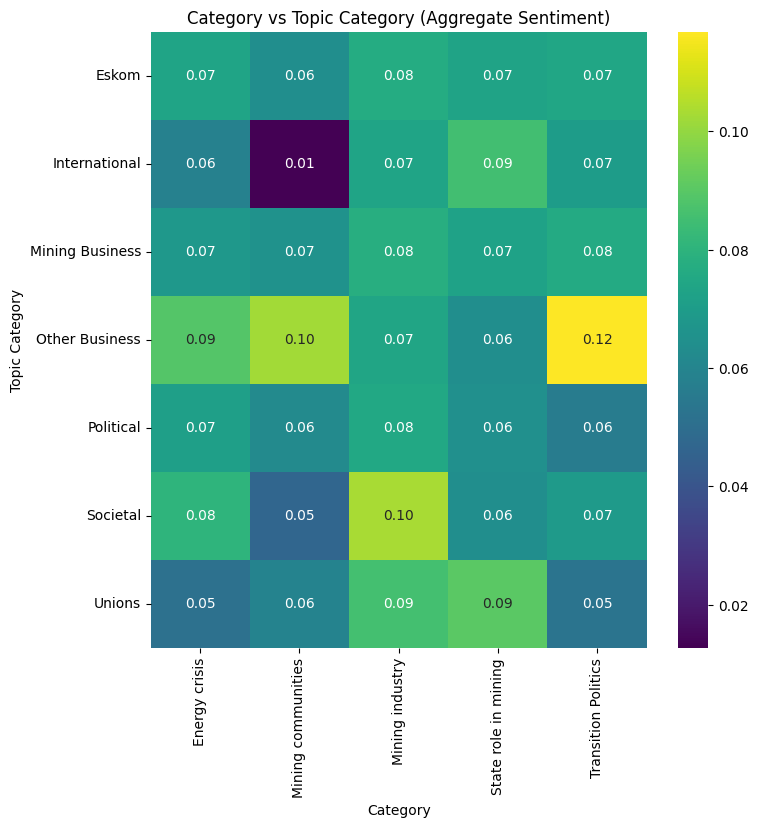

In [ ]:

sia = SIA()

# Function to calculate sentiment for each sentence
def calculate_sentiment(sentence):
    pol_score = sia.polarity_scores(sentence)
    return pol_score['compound'], pol_score['pos'], pol_score['neg'], pol_score['neu']

def polarity_score(compound):
    if compound > 0.05:
        return "positive"
    elif compound < -0.5:
        return "negative"
    elif compound >= -0.05 and compound < 0.05:
        return "neutral"



# Apply sentiment analysis to each sentence
sentiment_scores = df_subset['Sentence'].apply(calculate_sentiment)


df_subset[['Compound', 'Positive', 'Negative', 'Neutral']] = pd.DataFrame(sentiment_scores.tolist())
df_subset['sentiment'] = df_subset['compound'].apply(lambda val: polarity_score(val))
df_subset.head()


# Display the updated DataFrame with sentiment scores
print(df_subset.head())

# Aggregate sentiment scores by Entity and Year
aggregate_sentiment = df_subset.groupby(['Entity', 'Dominant Topic']).agg({ # Entity,
    'Compound': 'mean',
    'Positive': 'mean',
    'Negative': 'mean',
    'Neutral': 'mean'
}).reset_index()
# Aggregate sentiment scores by 'Category' and 'Topic Category'
df_agg_sentiment = df_subset.groupby(['Category', 'Topic Category'])['Positive'].mean().unstack().fillna(0)

# Plotting the heatmap
plt.subplots(figsize=(8, 8))
sns.heatmap(df_agg_sentiment, cmap='viridis', annot=True, fmt=".2f")
plt.xlabel('Category')
plt.ylabel('Topic Category')
plt.title('Category vs Topic Category (Aggregate Sentiment)')
plt.show()

<ipython-input-51-ab533557c63f>:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=melted_sentiment, x='Category', y='Score', hue='Sentiment', ci=None)


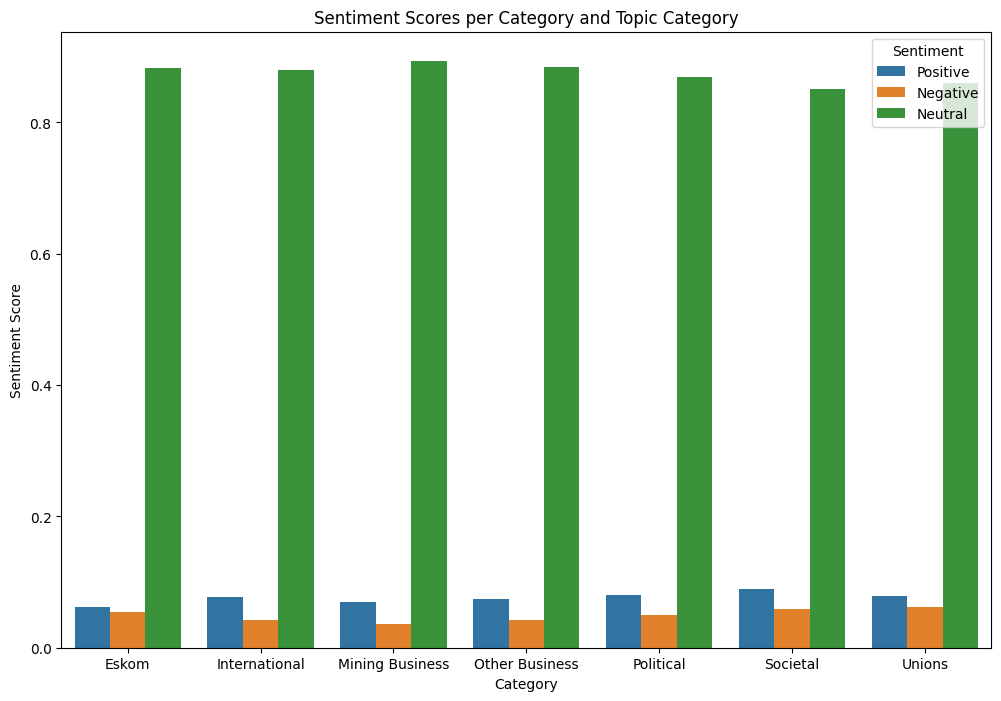

In [ ]:
# Apply sentiment analysis to each sentence
sentiment_scores = df_subset['Sentence'].apply(calculate_sentiment)
df_subset[['Compound', 'Positive', 'Negative', 'Neutral']] = pd.DataFrame(sentiment_scores.tolist(), index=df_subset.index)

# Aggregate sentiment scores by 'Category' and 'Topic Category'
aggregate_sentiment = df_subset.groupby(['Category', 'Topic Category']).agg({
    'Positive': 'mean',
    'Negative': 'mean',
    'Neutral': 'mean'
}).reset_index()



# Melt the DataFrame for seaborn
melted_sentiment = aggregate_sentiment.melt(id_vars=['Category', 'Topic Category'], value_vars=['Positive', 'Negative', 'Neutral'], var_name='Sentiment', value_name='Score')

# Plotting the bar plot
plt.figure(figsize=(12, 8))
sns.barplot(data=melted_sentiment, x='Category', y='Score', hue='Sentiment', ci=None)
plt.title('Sentiment Scores per Category and Topic Category')
plt.xlabel('Category')
plt.ylabel('Sentiment Score')
plt.legend(title='Sentiment')
plt.show()

                                             Sentence  \
1   Environmental groups rejected the dominance of...   
16  The problem of relying upon these actors to sa...   
17  The problem of relying upon these actors to sa...   
19  If Zuma aims, therefore, to persuade the world...   
21  The cuts promised by Sonjica just before Copen...   

                           Dominant Topic  Year  Month            Entity  \
1                            Eskom crisis  2010      1             Eskom   
16  Transition politics & climate finance  2010      1             Eskom   
17  Transition politics & climate finance  2010      1               ANC   
19  Transition politics & climate finance  2010      1              Zuma   
21  Transition politics & climate finance  2010      1  Earthlife Africa   

      Type   Category       Topic Category Time Period  Compound  Positive  \
1      ORG      Eskom        Energy crisis   2010-2015       0.0     0.160   
16     ORG      Eskom  Transition Politics  

<ipython-input-68-a59b263f32e8>:30: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=melted_sentiment, x='Category', y='Score', hue='Sentiment', ci=None)


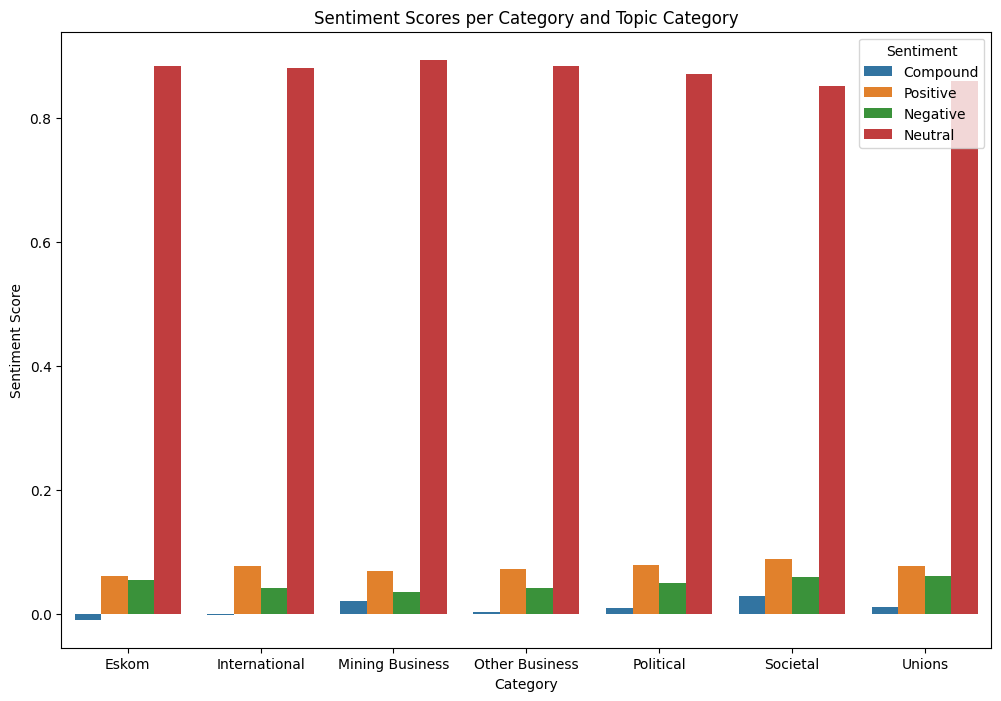

In [ ]:
sia = SIA()

# Function to calculate sentiment for each sentence with a custom threshold
def calculate_sentiment(sentence, neutral_threshold=0.2):
    pol_score = sia.polarity_scores(sentence)
    if abs(pol_score['compound']) < neutral_threshold:
        return 0, pol_score['pos'], pol_score['neg'], pol_score['neu']
    return pol_score['compound'], pol_score['pos'], pol_score['neg'], pol_score['neu']

# Apply sentiment analysis to each sentence
neutral_threshold = 0.8  # Increase this threshold to reduce neutral sentences
sentiment_scores = df_subset['Sentence'].apply(lambda x: calculate_sentiment(x, neutral_threshold))
df_subset[['Compound', 'Positive', 'Negative', 'Neutral']] = pd.DataFrame(sentiment_scores.tolist(), index=df_subset.index)

# Display the updated DataFrame with sentiment scores
print(df_subset.head())

# Aggregate sentiment scores by 'Category' and 'Topic Category'
aggregate_sentiment = df_subset.groupby(['Category', 'Topic Category']).agg({
    'Compound': 'mean',
    'Positive': 'mean',
    'Negative': 'mean',
    'Neutral': 'mean'
}).reset_index()
# Melt the DataFrame for seaborn
melted_sentiment = aggregate_sentiment.melt(id_vars=['Category', 'Topic Category'], value_vars=['Compound', 'Positive', 'Negative', 'Neutral'], var_name='Sentiment', value_name='Score')

# Plotting the bar plot
plt.figure(figsize=(12, 8))
sns.barplot(data=melted_sentiment, x='Category', y='Score', hue='Sentiment', ci=None)
plt.title('Sentiment Scores per Category and Topic Category')
plt.xlabel('Category')
plt.ylabel('Sentiment Score')
plt.legend(title='Sentiment')
plt.show()

<ipython-input-11-01e74f9213d8>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset[['Compound', 'Positive', 'Negative', 'Neutral']] = pd.DataFrame(sentiment_scores.tolist(), index=df_subset.index)
<ipython-input-11-01e74f9213d8>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset[['Compound', 'Positive', 'Negative', 'Neutral']] = pd.DataFrame(sentiment_scores.tolist(), index=df_subset.index)
<ipython-input-11-01e74f9213d8>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy o

                                             Sentence  \
1   Environmental groups rejected the dominance of...   
16  The problem of relying upon these actors to sa...   
17  The problem of relying upon these actors to sa...   
19  If Zuma aims, therefore, to persuade the world...   
21  The cuts promised by Sonjica just before Copen...   

                           Dominant Topic  Year  Month            Entity  \
1                            Eskom crisis  2010      1             Eskom   
16  Transition politics & climate finance  2010      1             Eskom   
17  Transition politics & climate finance  2010      1               ANC   
19  Transition politics & climate finance  2010      1        Jacob Zuma   
21  Transition politics & climate finance  2010      1  Earthlife Africa   

      Type   Category       Topic Category Broad Category  Compound  Positive  \
1      ORG      Eskom        Energy crisis          Eskom   -0.0258     0.160   
16     ORG      Eskom  Transition Poli

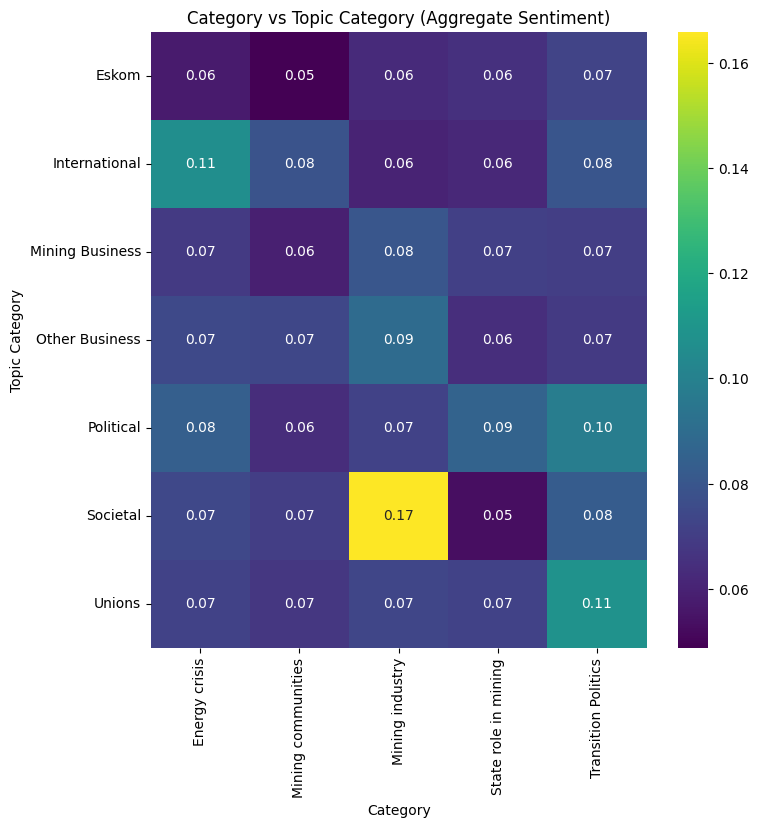

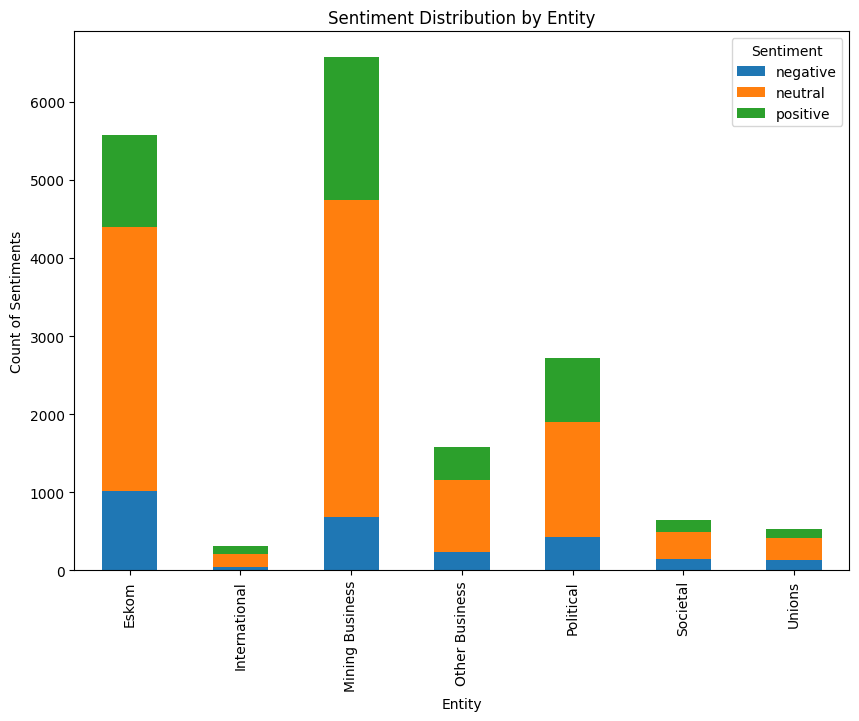

In [ ]:

# Initialize the sentiment intensity analyzer
sia = SIA()

# Function to calculate sentiment for each sentence
def calculate_sentiment(sentence):
    pol_score = sia.polarity_scores(sentence)
    return pol_score['compound'], pol_score['pos'], pol_score['neg'], pol_score['neu']


# Taken from here:  https://akladyous.medium.com/sentiment-analysis-using-vader-c56bcffe6f24

#def polarity_score(compound):
#    if compound > 0.05:
#        return "positive"
#    elif compound < -0.05:
#        return "negative"
#    else:
#        return "neutral"
def polarity_score(compound):
    if compound > 0.4:
        return "positive"
    elif compound < -0.4:
        return "negative"
    elif compound >= -0.4 and compound <= 0.4:
        return "neutral"
# Assuming df_subset is your DataFrame and it contains a column 'Sentence'
# Apply sentiment analysis to each sentence
sentiment_scores = df_subset['Sentence'].apply(calculate_sentiment)

# Create new columns in the DataFrame for the sentiment scores
df_subset[['Compound', 'Positive', 'Negative', 'Neutral']] = pd.DataFrame(sentiment_scores.tolist(), index=df_subset.index)
df_subset['Sentiment'] = df_subset['Compound'].apply(lambda val: polarity_score(val))

# Display the updated DataFrame with sentiment scores
print(df_subset.head())

# Aggregate sentiment scores by Entity and Dominant Topic
aggregate_sentiment = df_subset.groupby(['Entity', 'Dominant Topic']).agg({
    'Compound': 'mean',
    'Positive': 'mean',
    'Negative': 'mean',
    'Neutral': 'mean'
}).reset_index()

# Aggregate sentiment scores by 'Category' and 'Topic Category'
df_agg_sentiment = df_subset.groupby(['Category', 'Topic Category'])['Positive'].mean().unstack().fillna(0)

# Plotting the heatmap
plt.subplots(figsize=(8, 8))
sns.heatmap(df_agg_sentiment, cmap='viridis', annot=True, fmt=".2f")
plt.xlabel('Category')
plt.ylabel('Topic Category')
plt.title('Category vs Topic Category (Aggregate Sentiment)')
plt.show()


# Aggregate sentiment counts by 'Entity' and 'Sentiment'
sentiment_counts = df_subset.groupby(['Category', 'Sentiment']).size().unstack().fillna(0)

# Plotting the stacked bar plot
sentiment_counts.plot(kind='bar', stacked=True, figsize=(10, 7))
plt.xlabel('Entity')
plt.ylabel('Count of Sentiments')
plt.title('Sentiment Distribution by Entity')
plt.legend(title='Sentiment')
plt.show()

In [ ]:
# Pivot table to get mean compound sentiment by Entity and Dominant Topic
sentiment_pivot = df_agg_sentiment.pivot(index='Entity', columns='Dominant Topic', values='Compound')

# Plot heatmap for sentiment analysis by topic and entity
plt.figure(figsize=(12, 8))
sns.heatmap(sentiment_pivot, cmap='RdYlGn', annot=True, fmt=".2f", cbar_kws={'label': 'Mean Compound Sentiment'})
plt.title('Sentiment Analysis by Topic and Entity')
plt.xlabel('Dominant Topic')
plt.ylabel('Entity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


KeyError: 'Entity'

In [ ]:
# Print example sentences for each sentiment
print("\nExample Positive Sentences:")
print(df_subset[df_subset['Sentiment'] == 'positive']['Sentence'].head(5).tolist())

print("\nExample Negative Sentences:")
print(df_subset[df_subset['Sentiment'] == 'negative']['Sentence'].head(5).tolist())

print("\nExample Neutral Sentences:")
print(df_subset[df_subset['Sentiment'] == 'neutral']['Sentence'].head(5).tolist())



Example Positive Sentences:
['As the Eskom tariff hearings organised by the national energy regulator this week showed, Eskom is intent on a 35 percent annual increase the next three years so as to keep building coal-fired plants.', 'As the Eskom tariff hearings organised by the national energy regulator this week showed, Eskom is intent on a 35 percent annual increase the next three years so as to keep building coal-fired plants.', 'As the Eskom tariff hearings organised by the national energy regulator this week showed, Eskom is intent on a 35 percent annual increase the next three years so as to keep building coal-fired plants.', 'As the Eskom tariff hearings organised by the national energy regulator this week showed, Eskom is intent on a 35 percent annual increase the next three years so as to keep building coal-fired plants.', 'Yet the purpose of the new build programme is not to increase affordable energy, because the tiny rise in free basic electricity anticipated (from 50 to 

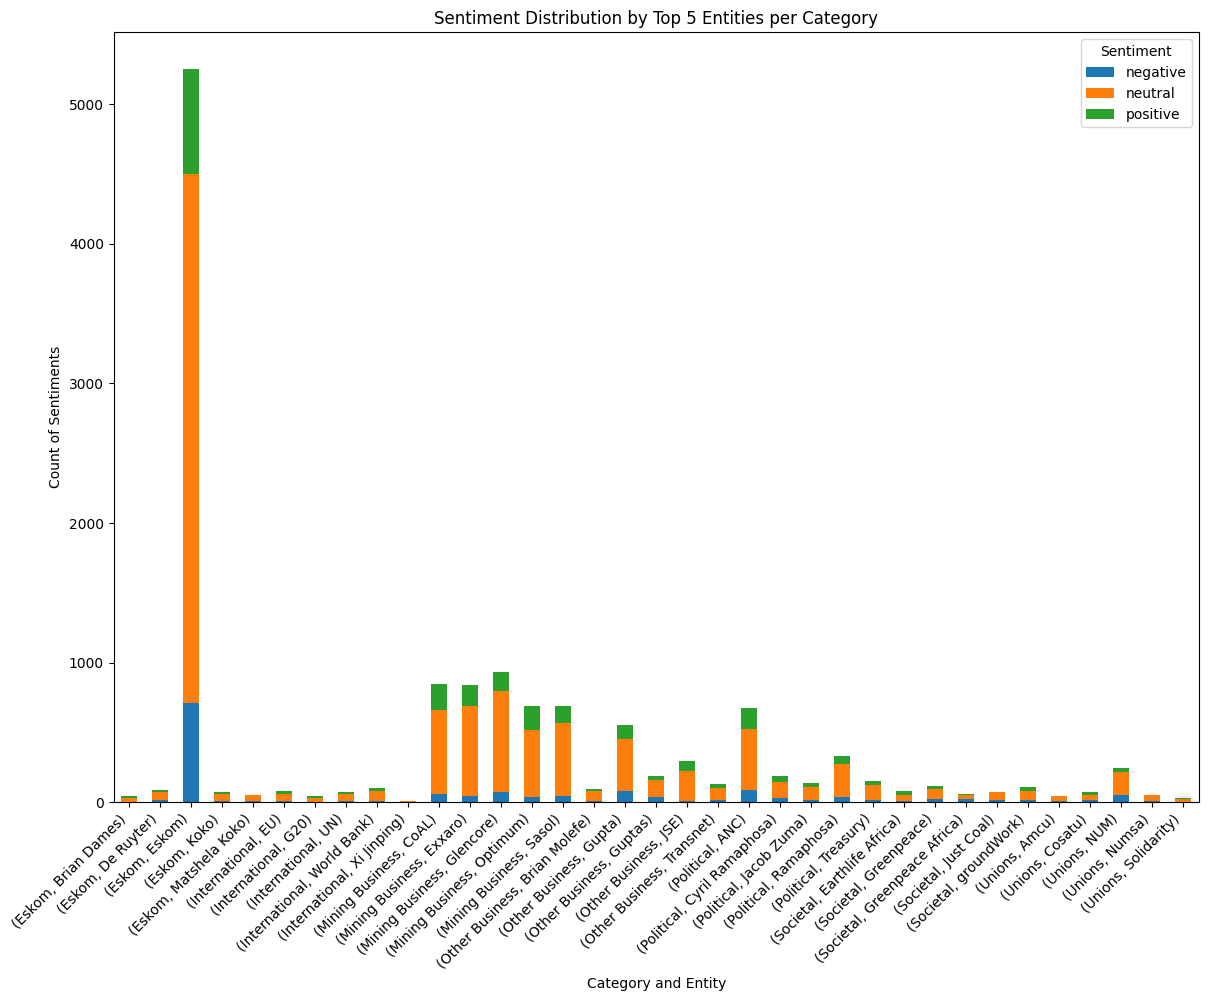

In [ ]:
# Find the top 5 most frequent entities within each category
top_5_per_category = df_subset.groupby(['Category', 'Entity']).size().reset_index(name='Counts')
top_5_per_category = top_5_per_category.groupby('Category').apply(lambda x: x.nlargest(5, 'Counts')).reset_index(drop=True)

# Filter the original DataFrame to include only these top entities
df_top_5 = df_subset[df_subset['Entity'].isin(top_5_per_category['Entity'])]

# Aggregate sentiment counts by 'Category', 'Entity', and 'Sentiment'
sentiment_counts_top_5 = df_top_5.groupby(['Category', 'Entity', 'Sentiment']).size().unstack().fillna(0)

# Plotting the stacked bar plot
fig, ax = plt.subplots(figsize=(14, 10))
sentiment_counts_top_5.plot(kind='bar', stacked=True, ax=ax)
ax.set_xlabel('Category and Entity')
ax.set_ylabel('Count of Sentiments')
ax.set_title('Sentiment Distribution by Top 5 Entities per Category')
ax.legend(title='Sentiment')
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
# Exclude all entities from the "Eskom" category
df_filtered = df_subset[df_subset['Category'] != 'Eskom']

# Find the top 5 most frequent entities within each remaining category
top_5_per_category = df_filtered.groupby(['Category', 'Entity']).size().reset_index(name='Counts')
top_5_per_category = top_5_per_category.groupby('Category').apply(lambda x: x.nlargest(5, 'Counts')).reset_index(drop=True)

# Calculate total frequencies per category
category_totals = df_filtered.groupby('Category').size().reset_index(name='Total Counts')
category_totals = category_totals.sort_values(by='Total Counts', ascending=False)

# Filter the original DataFrame to include only these top entities
df_top_5 = df_filtered[df_filtered['Entity'].isin(top_5_per_category['Entity'])]

# Merge to get the right order for plotting
df_top_5 = df_top_5.merge(category_totals[['Category']], on='Category', how='left')

# Aggregate sentiment counts by 'Category', 'Entity', and 'Sentiment'
sentiment_counts_top_5 = df_top_5.groupby(['Category', 'Entity', 'Sentiment']).size().unstack().fillna(0)

# Sort the index to reflect the order of categories by frequency
sentiment_counts_top_5 = sentiment_counts_top_5.loc[category_totals['Category']]
# Insert empty rows for spacing between categories
spacing_df = pd.DataFrame(columns=sentiment_counts_top_5.columns)
categories = sentiment_counts_top_5.index.get_level_values('Category').unique()
spaced_df = pd.concat(
    [sentiment_counts_top_5.loc[cat].append(spacing_df, ignore_index=True) for cat in categories]
).reset_index(drop=True)

# Plotting the stacked bar plot
fig, ax = plt.subplots(figsize=(14, 10))
sentiment_counts_top_5.plot(kind='bar', stacked=True, ax=ax)
ax.set_xlabel('Category and Entity')
ax.set_ylabel('Count of Sentiments')
ax.set_title('Sentiment Distribution by Top 5 Entities per Category (Excluding Eskom)')
ax.legend(title='Sentiment')
plt.xticks(rotation=45, ha='right')
plt.show()

AttributeError: 'DataFrame' object has no attribute 'append'

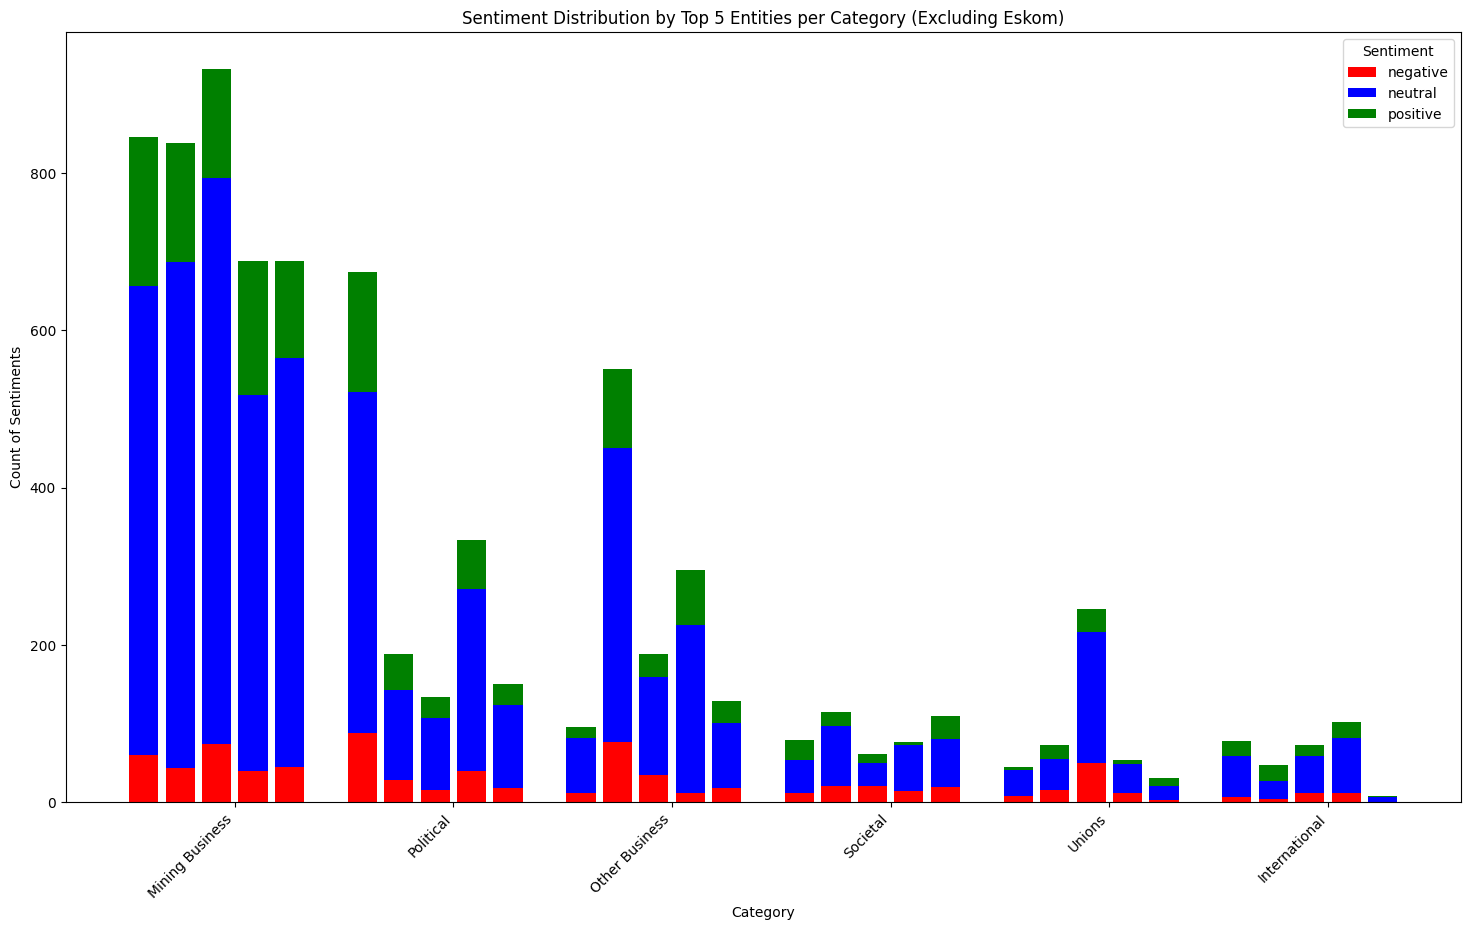

In [ ]:
# Check out: https://stackoverflow.com/questions/22787209/how-to-have-clusters-of-stacked-bars


# Exclude all entities from the "Eskom" category
df_filtered = df_subset[df_subset['Category'] != 'Eskom']

# Find the top 5 most frequent entities within each remaining category
top_5_per_category = df_filtered.groupby(['Category', 'Entity']).size().reset_index(name='Counts')
top_5_per_category = top_5_per_category.groupby('Category').apply(lambda x: x.nlargest(5, 'Counts')).reset_index(drop=True)

# Calculate total frequencies per category
category_totals = df_filtered.groupby('Category').size().reset_index(name='Total Counts')
category_totals = category_totals.sort_values(by='Total Counts', ascending=False)

# Filter the original DataFrame to include only these top entities
df_top_5 = df_filtered[df_filtered['Entity'].isin(top_5_per_category['Entity'])]

# Merge to get the right order for plotting
df_top_5 = df_top_5.merge(category_totals[['Category']], on='Category', how='left')

# Aggregate sentiment counts by 'Category', 'Entity', and 'Sentiment'
sentiment_counts_top_5 = df_top_5.groupby(['Category', 'Entity', 'Sentiment']).size().unstack().fillna(0)

# Sort the index to reflect the order of categories by frequency
sentiment_counts_top_5 = sentiment_counts_top_5.loc[category_totals['Category']]

# Plotting the grouped stacked bar plot
fig, ax = plt.subplots(figsize=(18, 10))

# Define colors for each sentiment
colors = {'positive': 'green', 'negative': 'red', 'neutral': 'blue'}

# Initialize the position for each bar
bar_width = 0.6
category_positions = []
current_position = 0

for category in sentiment_counts_top_5.index.get_level_values(0).unique():
    category_data = sentiment_counts_top_5.loc[category]
    entities = category_data.index
    for entity in entities:
        sentiments = category_data.loc[entity]
        bottom = 0
        for sentiment in sentiments.index:
            ax.bar(current_position, sentiments[sentiment], bottom=bottom, color=colors[sentiment], label=sentiment if current_position == 0 else "")
            bottom += sentiments[sentiment]
        current_position += 1
    category_positions.append((current_position - len(entities)) + (len(entities) / 2))
    current_position += 1  # Add space between categories

# Customize x-ticks to add space labels
ax.set_xticks(category_positions)
ax.set_xticklabels(category_totals['Category'], rotation=45, ha='right')
ax.set_xlabel('Category')
ax.set_ylabel('Count of Sentiments')
ax.set_title('Sentiment Distribution by Top 5 Entities per Category (Excluding Eskom)')
ax.legend(title='Sentiment')
plt.show()

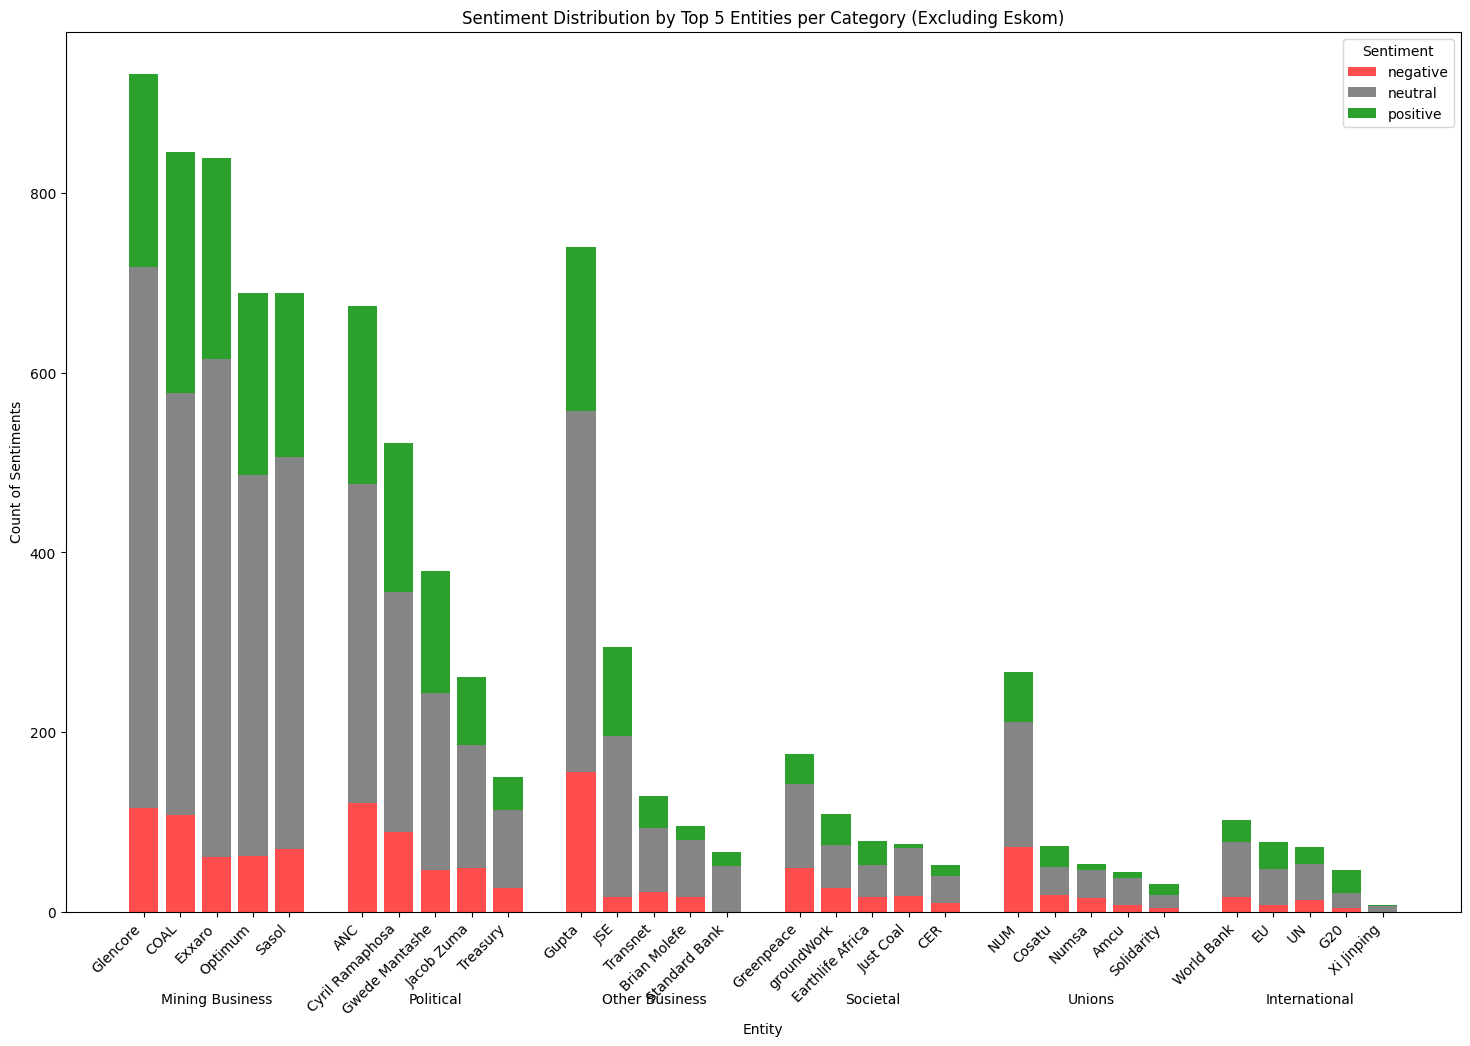

In [ ]:


# Exclude all entities from the "Eskom" category
df_filtered = df_subset[df_subset['Category'] != 'Eskom']

# Find the top 5 most frequent entities within each remaining category
top_5_per_category = df_filtered.groupby(['Category', 'Entity']).size().reset_index(name='Counts')
top_5_per_category = top_5_per_category.groupby('Category').apply(lambda x: x.nlargest(5, 'Counts')).reset_index(drop=True)

# Calculate total frequencies per category
category_totals = df_filtered.groupby('Category').size().reset_index(name='Total Counts')
category_totals = category_totals.sort_values(by='Total Counts', ascending=False)

# Filter the original DataFrame to include only these top entities
df_top_5 = df_filtered[df_filtered['Entity'].isin(top_5_per_category['Entity'])]

# Aggregate sentiment counts by 'Category', 'Entity', and 'Sentiment'
sentiment_counts_top_5 = df_top_5.groupby(['Category', 'Entity', 'Sentiment']).size().unstack().fillna(0)

# Sort the index to reflect the order of categories by frequency and entities by their counts within each category
sorted_index = top_5_per_category.set_index(['Category', 'Entity']).index
sentiment_counts_top_5 = sentiment_counts_top_5.loc[sorted_index]

# Plotting the grouped stacked bar plot
fig, ax = plt.subplots(figsize=(18, 10))

# Define colors for each sentiment
colors = {'positive': '#2ca02c', 'negative': '#ff4d4d', 'neutral': '#858585'}

# Initialize the position for each bar
bar_width = 0.6
category_positions = []
current_position = 0
entity_labels = []
category_labels = []
category_spacings = []

for category in category_totals['Category']:
    category_data = sentiment_counts_top_5.loc[category]
    entities = category_data.index
    start_position = current_position
    for entity in entities:
        sentiments = category_data.loc[entity]
        bottom = 0
        for sentiment in sentiments.index:
            ax.bar(current_position, sentiments[sentiment], bottom=bottom, color=colors[sentiment], label=sentiment if current_position == 0 else "")
            bottom += sentiments[sentiment]
        entity_labels.append(entity)
        current_position += 1
    end_position = current_position
    category_positions.append((start_position + end_position - 1) / 2)
    category_spacings.append((start_position, end_position - 1))
    current_position += 1  # Add space between categories
# Customize x-ticks to add entity names
ax.set_xticks([0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34])
new_entity_labels = ["Glencore", "COAL", "Exxaro", "Optimum", "Sasol",
                     "ANC", "Cyril Ramaphosa", "Gwede Mantashe", "Jacob Zuma", "Treasury",
                     "Gupta", "JSE", "Transnet", "Brian Molefe", "Standard Bank",
                     "Greenpeace", "groundWork", "Earthlife Africa", "Just Coal", "CER",
                     "NUM", "Cosatu", "Numsa", "Amcu", "Solidarity",
                     "World Bank", "EU", "UN", "G20", "Xi Jinping"]

ax.set_xticklabels(new_entity_labels, rotation=45, ha='right')


# Add category labels with brackets
bracket_y_pos = -max(sentiment_counts_top_5.max()) * 0.1  # Adjust based on your data range
for (start, end), category in zip(category_spacings, category_totals['Category']):
    ax.annotate('', xy=(start, bracket_y_pos), xytext=(end, bracket_y_pos), arrowprops=dict(arrowstyle='-[', lw=1.5))
    ax.text((start + end) / 2, bracket_y_pos * 1.5, category, ha='center', va='top', fontsize=10)

# Adjust the bottom margin to make space for the category labels
plt.subplots_adjust(bottom=0)

ax.set_xlabel('Entity')
ax.set_ylabel('Count of Sentiments')
ax.set_title('Sentiment Distribution by Top 5 Entities per Category (Excluding Eskom)')
ax.legend(title='Sentiment')
plt.show()

<ipython-input-29-8a4f23ebcf6e>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['Sentiment Score'] = df_subset['Sentence'].apply(calculate_sentiment)
<ipython-input-29-8a4f23ebcf6e>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['Sentiment Category'] = df_subset['Sentiment Score'].apply(polarity_score)
<ipython-input-29-8a4f23ebcf6e>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

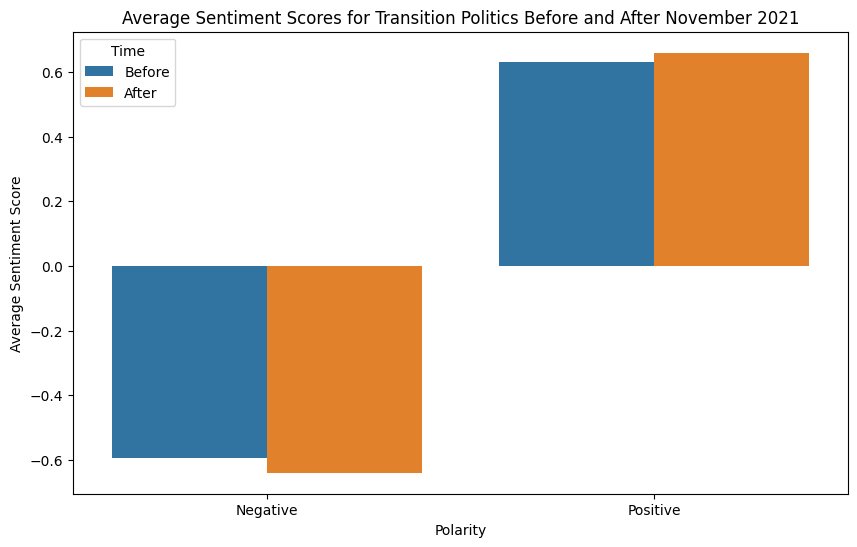

In [ ]:
# Initialize the sentiment intensity analyzer
sia = SIA()

# Function to calculate sentiment for each sentence
def calculate_sentiment(sentence):
    pol_score = sia.polarity_scores(sentence)
    return pol_score['compound']

def polarity_score(compound):
    if compound > 0.4:
        return "positive"
    elif compound < -0.4:
        return "negative"
    else:
        return "neutral"

# Add a column for sentiment scores
df_subset['Sentiment Score'] = df_subset['Sentence'].apply(calculate_sentiment)
# Add a column for sentiment categories based on thresholds
df_subset['Sentiment Category'] = df_subset['Sentiment Score'].apply(polarity_score)


df_transition = df_subset[df_subset['Topic Category'] == 'Transition Politics']

# Add a column for sentiment scores
df_transition['Sentiment Score'] = df_transition['Sentence'].apply(calculate_sentiment)
# Add a column for sentiment categories based on thresholds
df_transition['Sentiment Category'] = df_transition['Sentiment Score'].apply(polarity_score)

# Define the event date as November 2021
event_year = 2021
event_month = 11

# Split the dataset into before and after the event
df_before = df_transition[(df_transition['Year'] < event_year) | ((df_transition['Year'] == event_year) & (df_transition['Month'] < event_month))]
df_after = df_transition[(df_transition['Year'] > event_year) | ((df_transition['Year'] == event_year) & (df_transition['Month'] >= event_month))]

# Calculate average sentiment scores for each category before and after the event
average_sentiment_before_pos = df_before[df_before['Sentiment Category'] == 'positive']['Sentiment Score'].mean()
average_sentiment_after_pos = df_after[df_after['Sentiment Category'] == 'positive']['Sentiment Score'].mean()
average_sentiment_before_neg = df_before[df_before['Sentiment Category'] == 'negative']['Sentiment Score'].mean()
average_sentiment_after_neg = df_after[df_after['Sentiment Category'] == 'negative']['Sentiment Score'].mean()

# Create a DataFrame for plotting
plot_data = pd.DataFrame({
    'Polarity': ['Negative', 'Positive'],
    'Before': [average_sentiment_before_neg, average_sentiment_before_pos],
    'After': [average_sentiment_after_neg, average_sentiment_after_pos]
})

# Melt the DataFrame for easier plotting
plot_data_melted = plot_data.melt(id_vars='Polarity', var_name='Time', value_name='Average Sentiment Score')

# Plot the data
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='Polarity', y='Average Sentiment Score', hue='Time', data=plot_data_melted, palette=['#1f77b4', '#ff7f0e'])
ax.set_title('Average Sentiment Scores for Transition Politics Before and After November 2021')
ax.set_ylabel('Average Sentiment Score')
plt.show()

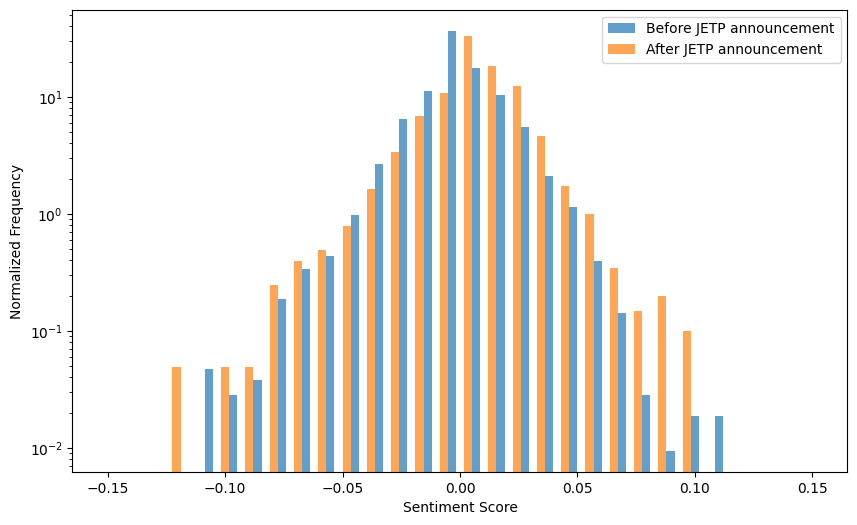

T-statistic: 2.545921284117487
P-value: 0.010956495529710453


In [ ]:
import numpy as np

# Initialize the sentiment intensity analyzer
sia = SIA()

# Function to calculate sentiment score for each word in a sentence
def calculate_word_sentiments(sentence):
    words = sentence.split()
    word_sentiments = [sia.polarity_scores(word)['compound'] for word in words]
    word_frequencies = Counter(words)
    return word_sentiments, word_frequencies

# Function to calculate the weighted average sentiment score for a sentence
def calculate_weighted_sentiment(sentence):
    word_sentiments, word_frequencies = calculate_word_sentiments(sentence)
    weighted_sum = sum(sentiment * word_frequencies[word] for word, sentiment in zip(word_frequencies.keys(), word_sentiments)) # The weight is the frequency of the word in the sentence
    total_weights = sum(word_frequencies.values())
    if total_weights == 0: # but this would mean that there is not word in the sentence
        return 0
    return weighted_sum / total_weights

#df_transition = df_subset[df_subset['Topic Category'] == 'Transition Politics']
df_transition = df_subset
# Add a column for weighted sentiment scores
df_transition['Weighted Sentiment Score'] = df_transition['Sentence'].apply(calculate_weighted_sentiment)

# Define the event date as November 2021
event_year = 2021
event_month = 11

# Split the dataset into before and after the event
df_before = df_transition[(df_transition['Year'] < event_year) | ((df_transition['Year'] == event_year) & (df_transition['Month'] < event_month))]
df_after = df_transition[(df_transition['Year'] > event_year) | ((df_transition['Year'] == event_year) & (df_transition['Month'] >= event_month))]

# Extract the weighted sentiment scores for before and after the event
scores_before = df_before['Weighted Sentiment Score'].values
scores_after = df_after['Weighted Sentiment Score'].values

# Define bins and compute histogram data
bins = np.linspace(-0.15, 0.15, 30)
hist_before, _ = np.histogram(df_before['Weighted Sentiment Score'], bins=bins, density=True)
hist_after, _ = np.histogram(df_after['Weighted Sentiment Score'], bins=bins, density=True)

# Compute the width of the bins
bin_width = bins[1] - bins[0]
bin_centers = (bins[:-1] + bins[1:]) / 2

# Plot the histograms as bar plots with a small gap between the groups
plt.figure(figsize=(10, 6))
plt.bar(bin_centers - bin_width/3, hist_before, width=bin_width/3, color='#1f77b4', label='Before JETP announcement', alpha=0.7)
plt.bar(bin_centers + bin_width/3, hist_after, width=bin_width/3, color='#ff7f0e', label='After JETP announcement', alpha=0.7)

plt.yscale('log')
plt.xlabel('Sentiment Score')
plt.ylabel('Normalized Frequency')
#plt.title('Normalized Histogram of Weighted Sentiment Scores Before and After November 2021')
plt.legend(title=None)
plt.show()



# Extract the weighted sentiment scores for before and after the event
scores_before = df_before['Weighted Sentiment Score'].values
scores_after = df_after['Weighted Sentiment Score'].values

# Perform the t-test
t_stat, p_value = ttest_ind(scores_before, scores_after, equal_var=False)

# Output the results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

In [ ]:
print(df_subset_2018)

                                                Sentence  \
619    Over the years, Eskom has found itself having ...   
622    The Anti-Poverty Forum alleges the bulk of the...   
625    The organisation further alleges that R93 mill...   
626    The money eaten away by the IPPs makes it diff...   
628    Eskom has detailed planning for maintenance an...   
...                                                  ...   
41541  You must be SIGNED IN to read comments Malema ...   
41542  You must be SIGNED IN to read comments Malema ...   
41547  The DA said what it called for last year was a...   
41556  A unit is located and embedded at Eskom and th...   
41570  The EFF believes in the development of South A...   

                              Dominant Topic  Year  Month           Entity  \
619                             Eskom crisis  2019      2            Eskom   
622                             Eskom crisis  2019      2            Eskom   
625                             Eskom crisis 

<ipython-input-20-01d10f5d5e8e>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transition_2018['Weighted Sentiment Score'] = df_transition_2018['Sentence'].apply(calculate_weighted_sentiment)


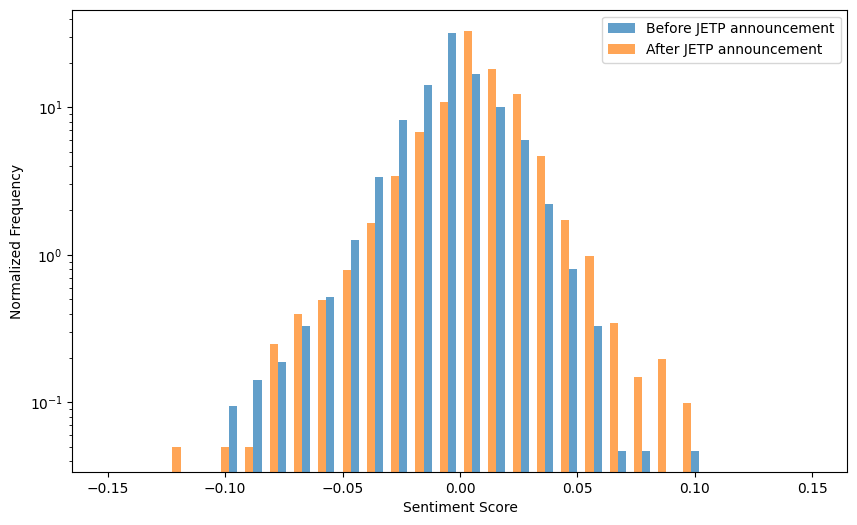

T-statistic: -0.15852595628356891
P-value: 0.8740504847671433


In [ ]:
# With different period! Two years before and two years after JETP -> Non siginificant difference

df_subset_2018 = df_subset[df_subset['Year'] > 2018 ]

# Initialize the sentiment intensity analyzer
sia = SIA()

# Function to calculate sentiment score for each word in a sentence
def calculate_word_sentiments(sentence):
    words = sentence.split()
    word_sentiments = [sia.polarity_scores(word)['compound'] for word in words]
    word_frequencies = Counter(words)
    return word_sentiments, word_frequencies

# Function to calculate the weighted average sentiment score for a sentence
def calculate_weighted_sentiment(sentence):
    word_sentiments, word_frequencies = calculate_word_sentiments(sentence)
    weighted_sum = sum(sentiment * word_frequencies[word] for word, sentiment in zip(word_frequencies.keys(), word_sentiments)) # The weight is the frequency of the word in the sentence
    total_weights = sum(word_frequencies.values())
    if total_weights == 0: # but this would mean that there is not word in the sentence
        return 0
    return weighted_sum / total_weights

# Filter the DataFrame to include only rows with the "Transition Politics" topic category
#df_transition_2018 = df_subset[df_subset['Topic Category'] == 'Transition Politics']
df_transition_2018 = df_subset_2018
# Add a column for weighted sentiment scores
df_transition_2018['Weighted Sentiment Score'] = df_transition_2018['Sentence'].apply(calculate_weighted_sentiment)

# Define the event date as November 2021
event_year = 2021
event_month = 11

# Split the dataset into before and after the event
df_before = df_transition_2018[(df_transition_2018['Year'] < event_year) | ((df_transition_2018['Year'] == event_year) & (df_transition_2018['Month'] < event_month))]
df_after = df_transition_2018[(df_subset_2018['Year'] > event_year) | ((df_transition_2018['Year'] == event_year) & (df_transition_2018['Month'] >= event_month))]

# Extract the weighted sentiment scores for before and after the event
scores_before = df_before['Weighted Sentiment Score'].values
scores_after = df_after['Weighted Sentiment Score'].values

# Define bins and compute histogram data
bins = np.linspace(-0.15, 0.15, 30)
hist_before, _ = np.histogram(df_before['Weighted Sentiment Score'], bins=bins, density=True)
hist_after, _ = np.histogram(df_after['Weighted Sentiment Score'], bins=bins, density=True)

# Compute the width of the bins
bin_width = bins[1] - bins[0]
bin_centers = (bins[:-1] + bins[1:]) / 2

# Plot the histograms as bar plots with a small gap between the groups
plt.figure(figsize=(10, 6))
plt.bar(bin_centers - bin_width/3, hist_before, width=bin_width/3, color='#1f77b4', label='Before JETP announcement', alpha=0.7)
plt.bar(bin_centers + bin_width/3, hist_after, width=bin_width/3, color='#ff7f0e', label='After JETP announcement', alpha=0.7)

plt.yscale('log')
plt.xlabel('Sentiment Score')
plt.ylabel('Normalized Frequency')
#plt.title('Normalized Histogram of Weighted Sentiment Scores Before and After November 2021')
plt.legend(title=None)
plt.show()



# Extract the weighted sentiment scores for before and after the event
scores_before = df_before['Weighted Sentiment Score'].values
scores_after = df_after['Weighted Sentiment Score'].values

# Perform the t-test
t_stat, p_value = ttest_ind(scores_before, scores_after, equal_var=False)

# Output the results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

<ipython-input-82-8332585bfc65>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transition_2018['Weighted Sentiment Score'] = df_transition_2018['Sentence'].apply(calculate_weighted_sentiment)
<ipython-input-82-8332585bfc65>:37: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_after = df_transition_2018[(df_subset_2018['Year'] > event_year) | ((df_transition_2018['Year'] == event_year) & (df_transition_2018['Month'] >= event_month))]


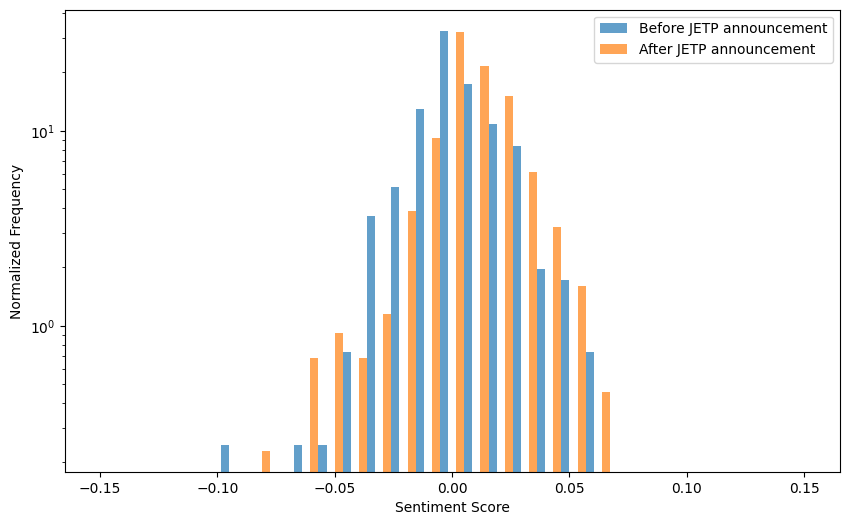

T-statistic: -1.1822197362774618
P-value: 0.23746519669867866


In [ ]:
# With different period! Two years before and two years after JETP only on Transition Politics -> Non siginificant difference

df_subset_2018 = df_subset[df_subset['Year'] > 2018 ]

# Initialize the sentiment intensity analyzer
sia = SIA()

# Function to calculate sentiment score for each word in a sentence
def calculate_word_sentiments(sentence):
    words = sentence.split()
    word_sentiments = [sia.polarity_scores(word)['compound'] for word in words]
    word_frequencies = Counter(words)
    return word_sentiments, word_frequencies

# Function to calculate the weighted average sentiment score for a sentence
def calculate_weighted_sentiment(sentence):
    word_sentiments, word_frequencies = calculate_word_sentiments(sentence)
    weighted_sum = sum(sentiment * word_frequencies[word] for word, sentiment in zip(word_frequencies.keys(), word_sentiments)) # The weight is the frequency of the word in the sentence
    total_weights = sum(word_frequencies.values())
    if total_weights == 0: # but this would mean that there is not word in the sentence
        return 0
    return weighted_sum / total_weights

# Filter the DataFrame to include only rows with the "Transition Politics" topic category
df_transition_2018 = df_subset_2018[df_subset_2018['Topic Category'] == 'Transition politics']
#df_transition_2018 = df_subset_2018
# Add a column for weighted sentiment scores
df_transition_2018['Weighted Sentiment Score'] = df_transition_2018['Sentence'].apply(calculate_weighted_sentiment)

# Define the event date as November 2021
event_year = 2021
event_month = 11

# Split the dataset into before and after the event
df_before = df_transition_2018[(df_transition_2018['Year'] < event_year) | ((df_transition_2018['Year'] == event_year) & (df_transition_2018['Month'] < event_month))]
df_after = df_transition_2018[(df_subset_2018['Year'] > event_year) | ((df_transition_2018['Year'] == event_year) & (df_transition_2018['Month'] >= event_month))]

# Extract the weighted sentiment scores for before and after the event
scores_before = df_before['Weighted Sentiment Score'].values
scores_after = df_after['Weighted Sentiment Score'].values

# Define bins and compute histogram data
bins = np.linspace(-0.15, 0.15, 30)
hist_before, _ = np.histogram(df_before['Weighted Sentiment Score'], bins=bins, density=True)
hist_after, _ = np.histogram(df_after['Weighted Sentiment Score'], bins=bins, density=True)

# Compute the width of the bins
bin_width = bins[1] - bins[0]
bin_centers = (bins[:-1] + bins[1:]) / 2

# Plot the histograms as bar plots with a small gap between the groups
plt.figure(figsize=(10, 6))
plt.bar(bin_centers - bin_width/3, hist_before, width=bin_width/3, color='#1f77b4', label='Before JETP announcement', alpha=0.7)
plt.bar(bin_centers + bin_width/3, hist_after, width=bin_width/3, color='#ff7f0e', label='After JETP announcement', alpha=0.7)

plt.yscale('log')
plt.xlabel('Sentiment Score')
plt.ylabel('Normalized Frequency')
#plt.title('Normalized Histogram of Weighted Sentiment Scores Before and After November 2021')
plt.legend(title=None)
plt.show()



# Extract the weighted sentiment scores for before and after the event
scores_before = df_before['Weighted Sentiment Score'].values
scores_after = df_after['Weighted Sentiment Score'].values

# Perform the t-test
t_stat, p_value = ttest_ind(scores_before, scores_after, equal_var=False)

# Output the results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

<ipython-input-19-6b8c3ff22338>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transition['Weighted Sentiment Score'] = df_transition['Sentence'].apply(calculate_weighted_sentiment)


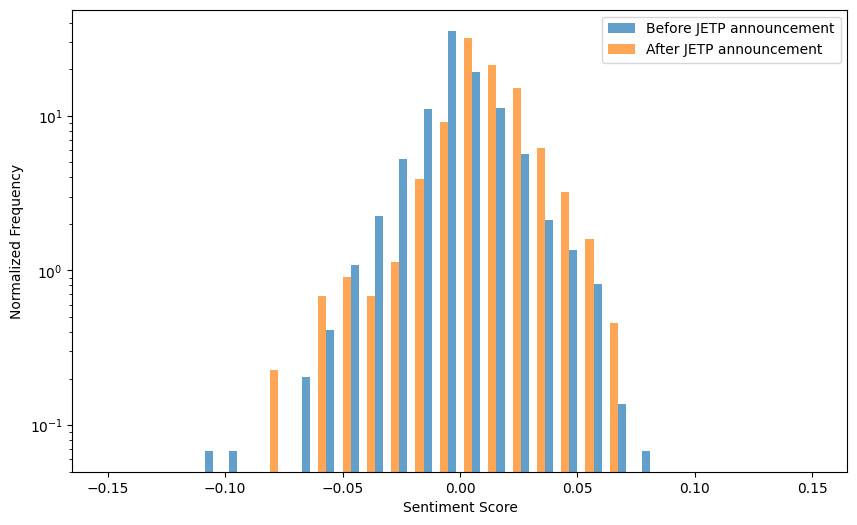

T-statistic: -1.5588181582984568
P-value: 0.11950387959431956


In [ ]:
# Now on whole period, but only on transition topics:

# With different period! Two years before and two years after JETP only on Transition Politics -> Non siginificant difference


# Initialize the sentiment intensity analyzer
sia = SIA()

# Function to calculate sentiment score for each word in a sentence
def calculate_word_sentiments(sentence):
    words = sentence.split()
    word_sentiments = [sia.polarity_scores(word)['compound'] for word in words]
    word_frequencies = Counter(words)
    return word_sentiments, word_frequencies

# Function to calculate the weighted average sentiment score for a sentence
def calculate_weighted_sentiment(sentence):
    word_sentiments, word_frequencies = calculate_word_sentiments(sentence)
    weighted_sum = sum(sentiment * word_frequencies[word] for word, sentiment in zip(word_frequencies.keys(), word_sentiments)) # The weight is the frequency of the word in the sentence
    total_weights = sum(word_frequencies.values())
    if total_weights == 0: # but this would mean that there is not word in the sentence
        return 0
    return weighted_sum / total_weights

# Filter the DataFrame to include only rows with the "Transition Politics" topic category
df_transition = df_subset[df_subset['Topic Category'] == 'Transition Politics']
#df_transition_2018 = df_subset_2018
# Add a column for weighted sentiment scores
df_transition['Weighted Sentiment Score'] = df_transition['Sentence'].apply(calculate_weighted_sentiment)

# Define the event date as November 2021
event_year = 2021
event_month = 11

# Split the dataset into before and after the event
df_before = df_transition[(df_transition['Year'] < event_year) | ((df_transition['Year'] == event_year) & (df_transition['Month'] < event_month))]
df_after = df_transition[(df_transition['Year'] > event_year) | ((df_transition['Year'] == event_year) & (df_transition['Month'] >= event_month))]

# Extract the weighted sentiment scores for before and after the event
scores_before = df_before['Weighted Sentiment Score'].values
scores_after = df_after['Weighted Sentiment Score'].values

# Define bins and compute histogram data
bins = np.linspace(-0.15, 0.15, 30)
hist_before, _ = np.histogram(df_before['Weighted Sentiment Score'], bins=bins, density=True)
hist_after, _ = np.histogram(df_after['Weighted Sentiment Score'], bins=bins, density=True)

# Compute the width of the bins
bin_width = bins[1] - bins[0]
bin_centers = (bins[:-1] + bins[1:]) / 2

# Plot the histograms as bar plots with a small gap between the groups
plt.figure(figsize=(10, 6))
plt.bar(bin_centers - bin_width/3, hist_before, width=bin_width/3, color='#1f77b4', label='Before JETP announcement', alpha=0.7)
plt.bar(bin_centers + bin_width/3, hist_after, width=bin_width/3, color='#ff7f0e', label='After JETP announcement', alpha=0.7)

plt.yscale('log')
plt.xlabel('Sentiment Score')
plt.ylabel('Normalized Frequency')
#plt.title('Normalized Histogram of Weighted Sentiment Scores Before and After November 2021')
plt.legend(title=None)
plt.show()



# Extract the weighted sentiment scores for before and after the event
scores_before = df_before['Weighted Sentiment Score'].values
scores_after = df_after['Weighted Sentiment Score'].values

# Perform the t-test
t_stat, p_value = ttest_ind(scores_before, scores_after, equal_var=False)

# Output the results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

<ipython-input-24-30f431fef87c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transition['Weighted Sentiment Score'] = df_transition['Sentence'].apply(calculate_weighted_sentiment)


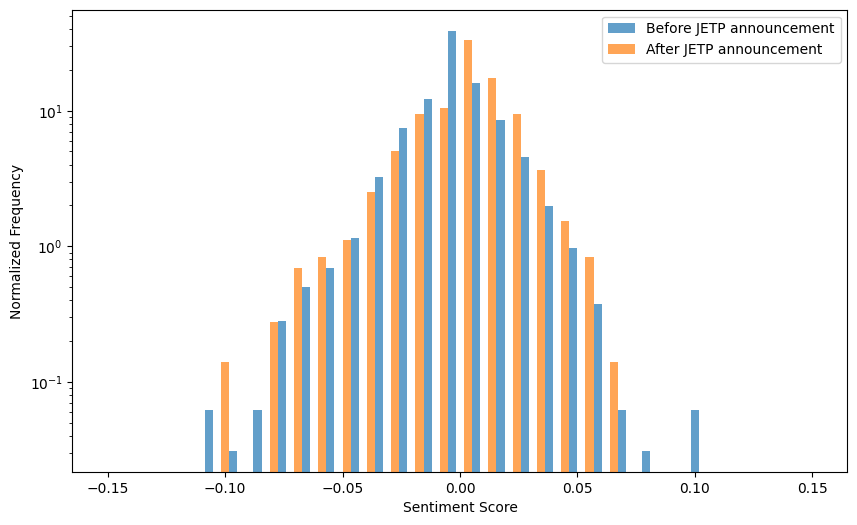

T-statistic: 3.3329415612317534
P-value: 0.0008923473765298033


In [ ]:
# Now for actor categories

# Initialize the sentiment intensity analyzer
sia = SIA()

# Function to calculate sentiment score for each word in a sentence
def calculate_word_sentiments(sentence):
    words = sentence.split()
    word_sentiments = [sia.polarity_scores(word)['compound'] for word in words]
    word_frequencies = Counter(words)
    return word_sentiments, word_frequencies

# Function to calculate the weighted average sentiment score for a sentence
def calculate_weighted_sentiment(sentence):
    word_sentiments, word_frequencies = calculate_word_sentiments(sentence)
    weighted_sum = sum(sentiment * word_frequencies[word] for word, sentiment in zip(word_frequencies.keys(), word_sentiments)) # The weight is the frequency of the word in the sentence
    total_weights = sum(word_frequencies.values())
    if total_weights == 0: # but this would mean that there is not word in the sentence
        return 0
    return weighted_sum / total_weights

# Filter the DataFrame to include only rows with the "Transition Politics" topic category
df_transition = df_subset[df_subset['Category'] == 'Eskom']
#df_transition_2018 = df_subset_2018
# Add a column for weighted sentiment scores
df_transition['Weighted Sentiment Score'] = df_transition['Sentence'].apply(calculate_weighted_sentiment)

# Define the event date as November 2021
event_year = 2021
event_month = 11

# Split the dataset into before and after the event
df_before = df_transition[(df_transition['Year'] < event_year) | ((df_transition['Year'] == event_year) & (df_transition['Month'] < event_month))]
df_after = df_transition[(df_transition['Year'] > event_year) | ((df_transition['Year'] == event_year) & (df_transition['Month'] >= event_month))]

# Extract the weighted sentiment scores for before and after the event
scores_before = df_before['Weighted Sentiment Score'].values
scores_after = df_after['Weighted Sentiment Score'].values

# Define bins and compute histogram data
bins = np.linspace(-0.15, 0.15, 30)
hist_before, _ = np.histogram(df_before['Weighted Sentiment Score'], bins=bins, density=True)
hist_after, _ = np.histogram(df_after['Weighted Sentiment Score'], bins=bins, density=True)

# Compute the width of the bins
bin_width = bins[1] - bins[0]
bin_centers = (bins[:-1] + bins[1:]) / 2

# Plot the histograms as bar plots with a small gap between the groups
plt.figure(figsize=(10, 6))
plt.bar(bin_centers - bin_width/3, hist_before, width=bin_width/3, color='#1f77b4', label='Before JETP announcement', alpha=0.7)
plt.bar(bin_centers + bin_width/3, hist_after, width=bin_width/3, color='#ff7f0e', label='After JETP announcement', alpha=0.7)

plt.yscale('log')
plt.xlabel('Sentiment Score')
plt.ylabel('Normalized Frequency')
#plt.title('Normalized Histogram of Weighted Sentiment Scores Before and After November 2021')
plt.legend(title=None)
plt.show()



# Extract the weighted sentiment scores for before and after the event
scores_before = df_before['Weighted Sentiment Score'].values
scores_after = df_after['Weighted Sentiment Score'].values

# Perform the t-test
t_stat, p_value = ttest_ind(scores_before, scores_after, equal_var=False)

# Output the results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

<ipython-input-75-316b5cd25910>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transition['Weighted Sentiment Score'] = df_transition['Sentence'].apply(calculate_weighted_sentiment)


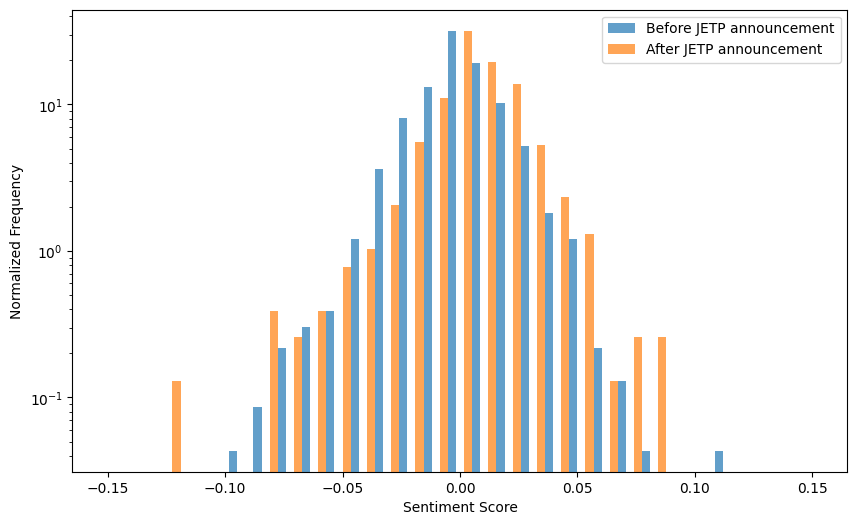

T-statistic: -2.0437289505939793
P-value: 0.04119884428094781


In [ ]:
# Now for actor categories - Political Societal Unions

# Initialize the sentiment intensity analyzer
sia = SIA()

# Function to calculate sentiment score for each word in a sentence
def calculate_word_sentiments(sentence):
    words = sentence.split()
    word_sentiments = [sia.polarity_scores(word)['compound'] for word in words]
    word_frequencies = Counter(words)
    return word_sentiments, word_frequencies

# Function to calculate the weighted average sentiment score for a sentence
def calculate_weighted_sentiment(sentence):
    word_sentiments, word_frequencies = calculate_word_sentiments(sentence)
    weighted_sum = sum(sentiment * word_frequencies[word] for word, sentiment in zip(word_frequencies.keys(), word_sentiments)) # The weight is the frequency of the word in the sentence
    total_weights = sum(word_frequencies.values())
    if total_weights == 0: # but this would mean that there is not word in the sentence
        return 0
    return weighted_sum / total_weights

# Filter the DataFrame to include only rows with the "Transition Politics" topic category
df_transition = df_subset[(df_subset['Category'] == 'Political') | (df_subset['Category'] == 'Unions') | (df_subset['Category'] == 'Societal')]
#df_transition_2018 = df_subset_2018
# Add a column for weighted sentiment scores
df_transition['Weighted Sentiment Score'] = df_transition['Sentence'].apply(calculate_weighted_sentiment)

# Define the event date as November 2021
event_year = 2021
event_month = 11

# Split the dataset into before and after the event
df_before = df_transition[(df_transition['Year'] < event_year) | ((df_transition['Year'] == event_year) & (df_transition['Month'] < event_month))]
df_after = df_transition[(df_transition['Year'] > event_year) | ((df_transition['Year'] == event_year) & (df_transition['Month'] >= event_month))]

# Extract the weighted sentiment scores for before and after the event
scores_before = df_before['Weighted Sentiment Score'].values
scores_after = df_after['Weighted Sentiment Score'].values

# Define bins and compute histogram data
bins = np.linspace(-0.15, 0.15, 30)
hist_before, _ = np.histogram(df_before['Weighted Sentiment Score'], bins=bins, density=True)
hist_after, _ = np.histogram(df_after['Weighted Sentiment Score'], bins=bins, density=True)

# Compute the width of the bins
bin_width = bins[1] - bins[0]
bin_centers = (bins[:-1] + bins[1:]) / 2

# Plot the histograms as bar plots with a small gap between the groups
plt.figure(figsize=(10, 6))
plt.bar(bin_centers - bin_width/3, hist_before, width=bin_width/3, color='#1f77b4', label='Before JETP announcement', alpha=0.7)
plt.bar(bin_centers + bin_width/3, hist_after, width=bin_width/3, color='#ff7f0e', label='After JETP announcement', alpha=0.7)

plt.yscale('log')
plt.xlabel('Sentiment Score')
plt.ylabel('Normalized Frequency')
#plt.title('Normalized Histogram of Weighted Sentiment Scores Before and After November 2021')
plt.legend(title=None)
plt.show()



# Extract the weighted sentiment scores for before and after the event
scores_before = df_before['Weighted Sentiment Score'].values
scores_after = df_after['Weighted Sentiment Score'].values

# Perform the t-test
t_stat, p_value = ttest_ind(scores_before, scores_after, equal_var=False)

# Output the results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

<ipython-input-84-ff7675792e4f>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transition['Weighted Sentiment Score'] = df_transition['Sentence'].apply(calculate_weighted_sentiment)
<ipython-input-84-ff7675792e4f>:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_after = df_transition_2018[(df_transition['Year'] > event_year) | ((df_transition['Year'] == event_year) & (df_transition['Month'] >= event_month))]


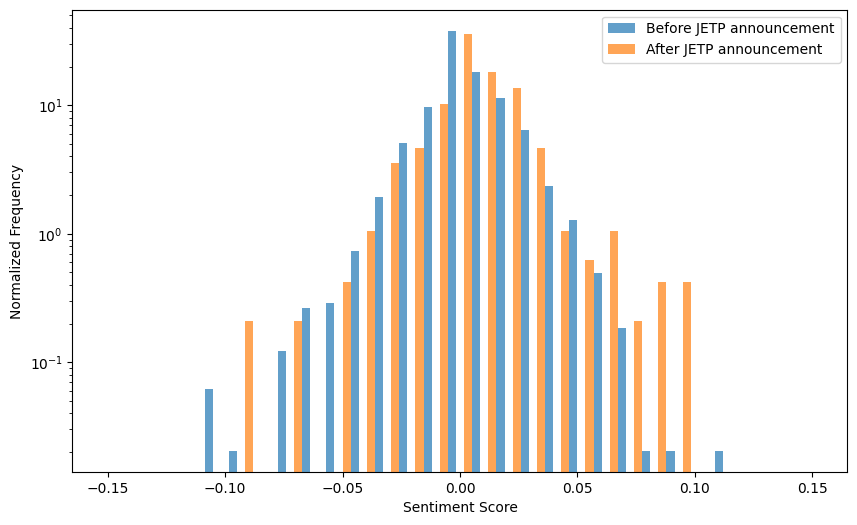

T-statistic: 0.8713458423739949
P-value: 0.3839552119500378


In [ ]:
# Now for actor categories - Business!
df_subset_2018 = df_subset[df_subset['Year'] > 2018 ]

# Initialize the sentiment intensity analyzer
sia = SIA()

# Function to calculate sentiment score for each word in a sentence
def calculate_word_sentiments(sentence):
    words = sentence.split()
    word_sentiments = [sia.polarity_scores(word)['compound'] for word in words]
    word_frequencies = Counter(words)
    return word_sentiments, word_frequencies

# Function to calculate the weighted average sentiment score for a sentence
def calculate_weighted_sentiment(sentence):
    word_sentiments, word_frequencies = calculate_word_sentiments(sentence)
    weighted_sum = sum(sentiment * word_frequencies[word] for word, sentiment in zip(word_frequencies.keys(), word_sentiments)) # The weight is the frequency of the word in the sentence
    total_weights = sum(word_frequencies.values())
    if total_weights == 0: # but this would mean that there is not word in the sentence
        return 0
    return weighted_sum / total_weights

# Filter the DataFrame to include only rows with the "Transition Politics" topic category
df_transition = df_subset[(df_subset['Category'] == 'Mining Business') | (df_subset['Category'] == 'Other Business')]
#df_transition_2018 = df_subset_2018
# Add a column for weighted sentiment scores
df_transition['Weighted Sentiment Score'] = df_transition['Sentence'].apply(calculate_weighted_sentiment)

# Define the event date as November 2021
event_year = 2021
event_month = 11

# Split the dataset into before and after the event
df_before = df_transition[(df_transition['Year'] < event_year) | ((df_transition['Year'] == event_year) & (df_transition['Month'] < event_month))]
df_after = df_transition_2018[(df_transition['Year'] > event_year) | ((df_transition['Year'] == event_year) & (df_transition['Month'] >= event_month))]

# Extract the weighted sentiment scores for before and after the event
scores_before = df_before['Weighted Sentiment Score'].values
scores_after = df_after['Weighted Sentiment Score'].values

# Define bins and compute histogram data
bins = np.linspace(-0.15, 0.15, 30)
hist_before, _ = np.histogram(df_before['Weighted Sentiment Score'], bins=bins, density=True)
hist_after, _ = np.histogram(df_after['Weighted Sentiment Score'], bins=bins, density=True)

# Compute the width of the bins
bin_width = bins[1] - bins[0]
bin_centers = (bins[:-1] + bins[1:]) / 2

# Plot the histograms as bar plots with a small gap between the groups
plt.figure(figsize=(10, 6))
plt.bar(bin_centers - bin_width/3, hist_before, width=bin_width/3, color='#1f77b4', label='Before JETP announcement', alpha=0.7)
plt.bar(bin_centers + bin_width/3, hist_after, width=bin_width/3, color='#ff7f0e', label='After JETP announcement', alpha=0.7)

plt.yscale('log')
plt.xlabel('Sentiment Score')
plt.ylabel('Normalized Frequency')
#plt.title('Normalized Histogram of Weighted Sentiment Scores Before and After November 2021')
plt.legend(title=None)
plt.show()



# Extract the weighted sentiment scores for before and after the event
scores_before = df_before['Weighted Sentiment Score'].values
scores_after = df_after['Weighted Sentiment Score'].values

# Perform the t-test
t_stat, p_value = ttest_ind(scores_before, scores_after, equal_var=False)

# Output the results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

<ipython-input-50-5b30157e10e5>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transition['Weighted Sentiment Score'] = df_transition['Sentence'].apply(calculate_weighted_sentiment)


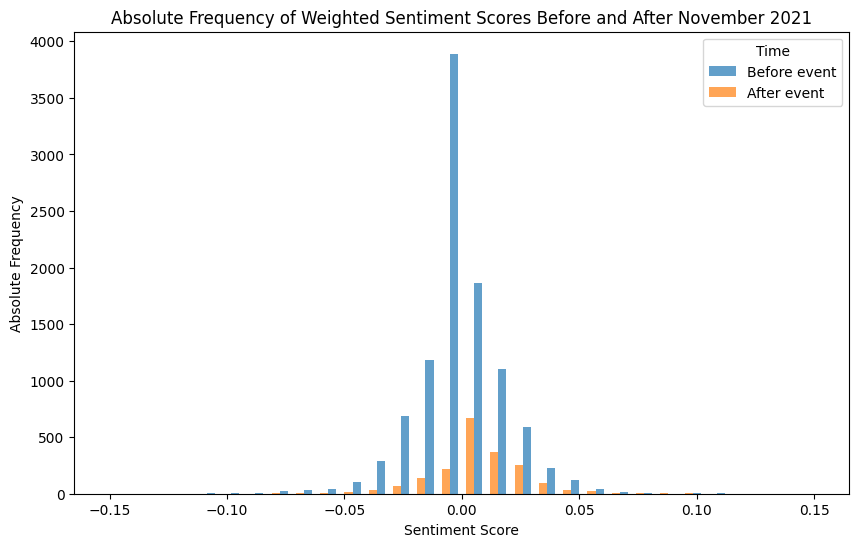

T-statistic: 2.545921284117487
P-value: 0.010956495529710453


In [ ]:
from scipy.stats import ttest_ind


# Initialize the sentiment intensity analyzer
sia = SIA()

# Function to calculate sentiment score for each word in a sentence
def calculate_word_sentiments(sentence):
    words = sentence.split()
    word_sentiments = [sia.polarity_scores(word)['compound'] for word in words]
    word_frequencies = Counter(words)
    return word_sentiments, word_frequencies

# Function to calculate the weighted average sentiment score for a sentence
def calculate_weighted_sentiment(sentence):
    word_sentiments, word_frequencies = calculate_word_sentiments(sentence)
    weighted_sum = sum(sentiment * word_frequencies[word] for word, sentiment in zip(word_frequencies.keys(), word_sentiments))
    total_weights = sum(word_frequencies.values())
    if total_weights == 0:
        return 0
    return weighted_sum / total_weights

# Filter the DataFrame to include only rows with the "Transition Politics" topic category
#df_transition = df_subset[df_subset['Topic Category'] == 'Transition Politics']
df_transition = df_subset
# Add a column for weighted sentiment scores
df_transition['Weighted Sentiment Score'] = df_transition['Sentence'].apply(calculate_weighted_sentiment)

# Define the event date as November 2021
event_year = 2021
event_month = 11

# Split the dataset into before and after the event
df_before = df_transition[(df_transition['Year'] < event_year) | ((df_transition['Year'] == event_year) & (df_transition['Month'] < event_month))]
df_after = df_transition[(df_transition['Year'] > event_year) | ((df_transition['Year'] == event_year) & (df_transition['Month'] >= event_month))]

# Extract the weighted sentiment scores for before and after the event
scores_before = df_before['Weighted Sentiment Score'].values
scores_after = df_after['Weighted Sentiment Score'].values

# Define bins and compute histogram data
bins = np.linspace(-0.15, 0.15, 30)
hist_before, _ = np.histogram(scores_before, bins=bins, density=False)
hist_after, _ = np.histogram(scores_after, bins=bins, density=False)

# Compute the width of the bins
bin_width = bins[1] - bins[0]
bin_centers = (bins[:-1] + bins[1:]) / 2

# Plot the histograms as bar plots with a small gap between the groups
plt.figure(figsize=(10, 6))
plt.bar(bin_centers - bin_width/3, hist_before, width=bin_width/3, color='#1f77b4', label='Before event', alpha=0.7)
plt.bar(bin_centers + bin_width/3, hist_after, width=bin_width/3, color='#ff7f0e', label='After event', alpha=0.7)

plt.xlabel('Sentiment Score')
plt.ylabel('Absolute Frequency')
plt.title('Absolute Frequency of Weighted Sentiment Scores Before and After November 2021')
plt.legend(title='Time')
plt.show()

# Perform the t-test
t_stat, p_value = ttest_ind(scores_before, scores_after, equal_var=False)

# Output the results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")



No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
<ipython-input-53-3cc576dab71b>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset2[['Sentiment', 'Score']] = pd.DataFrame(sentiment_scores.tolist(), index=df_subset2

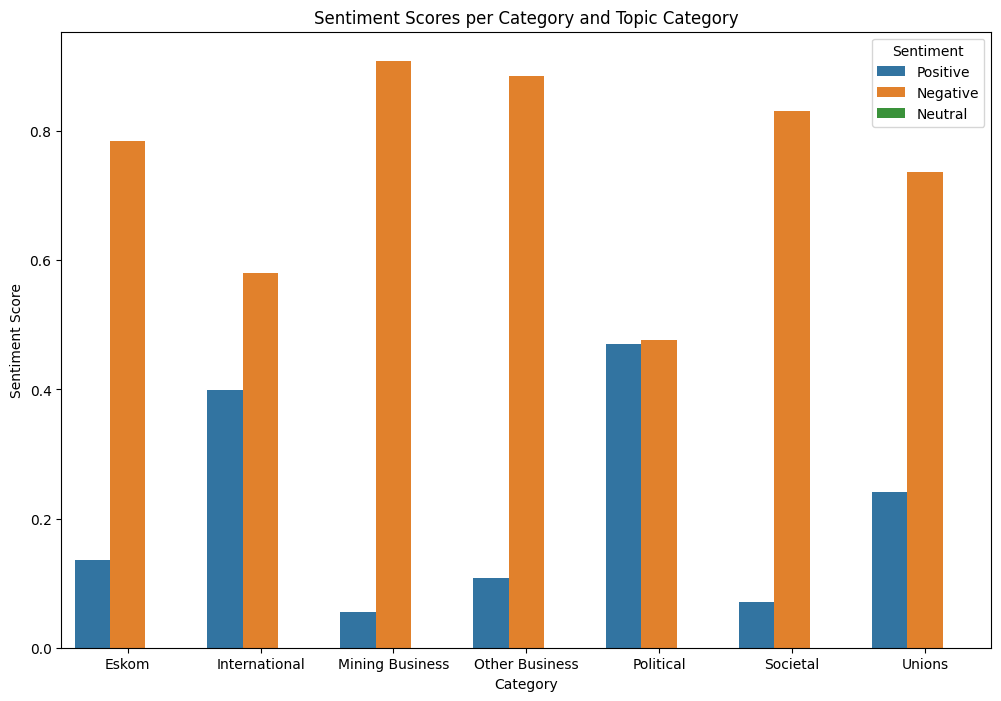

In [ ]:
df_subset2 = df_subset.head(300)

# Initialize BERT sentiment analysis pipeline
sentiment_pipeline = pipeline('sentiment-analysis', model="distilbert-base-uncased-finetuned-sst-2-english")

# Function to calculate sentiment for each sentence
def calculate_sentiment(sentence):
    result = sentiment_pipeline(sentence)[0]
    sentiment = result['label']
    score = result['score']
 #       if score < 0.3:  # Custom threshold for neutral sentiment
 #       sentiment = 'NEUTRAL'
    return sentiment, score

# Apply sentiment analysis to each sentence
sentiment_scores = df_subset2['Sentence'].apply(calculate_sentiment)
df_subset2[['Sentiment', 'Score']] = pd.DataFrame(sentiment_scores.tolist(), index=df_subset2.index)

# Map BERT sentiments to Positive, Negative, and Neutral
df_subset2['Positive'] = df_subset2.apply(lambda x: x['Score'] if x['Sentiment'] == 'POSITIVE' else 0, axis=1)
df_subset2['Negative'] = df_subset2.apply(lambda x: x['Score'] if x['Sentiment'] == 'NEGATIVE' else 0, axis=1)
df_subset2['Neutral'] = df_subset2.apply(lambda x: x['Score'] if x['Sentiment'] == 'NEUTRAL' else 0, axis=1)

# Aggregate sentiment scores by 'Category' and 'Topic Category'
aggregate_sentiment = df_subset2.groupby(['Category', 'Topic Category']).agg({
    'Positive': 'mean',
    'Negative': 'mean',
    'Neutral': 'mean'
}).reset_index()

# Melt the DataFrame for seaborn
melted_sentiment = aggregate_sentiment.melt(id_vars=['Category', 'Topic Category'], value_vars=['Positive', 'Negative', 'Neutral'], var_name='Sentiment', value_name='Score')

# Plotting the bar plot
plt.figure(figsize=(12, 8))
sns.barplot(data=melted_sentiment, x='Category', y='Score', hue='Sentiment', ci=None)
plt.title('Sentiment Scores per Category and Topic Category')
plt.xlabel('Category')
plt.ylabel('Sentiment Score')
plt.legend(title='Sentiment')
plt.show()
